## github
https://github.com/saugatshakya/predicting_car_price

## live demo
https://carprice-predict.ambitiousisland-1be3b1ed.southeastasia.azurecontainerapps.io/

In [15]:
import mlflow

# Set the experiment name
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Car_Price_Regression_Experiments")

<Experiment: artifact_location='mlflow-artifacts:/839360960728144798', creation_time=1757748339823, experiment_id='839360960728144798', last_update_time=1757748339823, lifecycle_stage='active', name='Car_Price_Regression_Experiments', tags={}>

In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

In [17]:
# Load the dataset
data = pd.read_csv("cars.csv")
print("Dataset loaded successfully!")
print(f"Original dataset shape: {data.shape}")

Dataset loaded successfully!
Original dataset shape: (8128, 13)


In [18]:
# Display basic information about the dataset
print("\nDataset Info:")
data.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [19]:
# Display first few rows
print("\nFirst 5 rows:")
data.head()


First 5 rows:


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [20]:
# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())


Missing values in each column:
name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64


In [21]:
# Check for duplicates
print(f"\nNumber of duplicates: {data.duplicated().sum()}")


Number of duplicates: 1202


In [22]:
# Remove duplicates
data = data.drop_duplicates()
print(f"Dataset shape after removing duplicates: {data.shape}")

Dataset shape after removing duplicates: (6926, 13)


In [23]:
# Remove CNG and LPG fuel types as instructed
data = data[~data['fuel'].isin(['CNG', 'LPG'])]
print(f"Dataset shape after removing CNG/LPG: {data.shape}")

Dataset shape after removing CNG/LPG: (6832, 13)


In [24]:
# Clean mileage column
data['mileage'] = (
    data['mileage']
    .str.replace('kmpl', '', regex=False)
    .str.replace('km/kg', '', regex=False)
    .str.strip()
)
data['mileage'] = pd.to_numeric(data['mileage'], errors='coerce')

In [25]:
# Clean engine column
data['engine'] = (
    data['engine']
    .str.replace('CC', '', regex=False)
    .str.strip()
)
data['engine'] = pd.to_numeric(data['engine'], errors='coerce')


In [26]:
# Clean max_power column
data['max_power'] = (
    data['max_power']
    .str.replace('bhp', '', regex=False)
    .str.strip()
)
data['max_power'] = pd.to_numeric(data['max_power'], errors='coerce')

In [27]:
# Fill missing values in seats with mode
data['seats'] = data['seats'].fillna(data['seats'].mode()[0])

In [28]:
# Fill other missing values with median
for col in ['mileage', 'engine', 'max_power']:
    data[col] = data[col].fillna(data[col].median())

In [29]:
# Drop torque column as instructed
data.drop(columns=['torque'], inplace=True)

In [30]:
# Map owner values as instructed
owner_map = {
    'First Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3,
    'Fourth & Above Owner': 4,
    'Test Drive Car': 5
}
data['owner'] = data['owner'].map(owner_map)

In [31]:
# Remove test drive cars as instructed
data = data[data['owner'] != 5]
print(f"Dataset shape after removing test drive cars: {data.shape}")

Dataset shape after removing test drive cars: (6827, 12)


In [32]:
# Extract brand from name
data['brand'] = data['name'].str.split().str[0]
data['brand'] = data['brand'].fillna('Unknown')
data.drop(columns=['name'], inplace=True)

In [33]:
#see all brand column unique values
print("\nUnique brands in the dataset:")
print(data['brand'].unique())


Unique brands in the dataset:
['Maruti' 'Skoda' 'Honda' 'Hyundai' 'Toyota' 'Ford' 'Renault' 'Mahindra'
 'Tata' 'Chevrolet' 'Fiat' 'Datsun' 'Jeep' 'Mercedes-Benz' 'Mitsubishi'
 'Audi' 'Volkswagen' 'BMW' 'Nissan' 'Lexus' 'Jaguar' 'Land' 'MG' 'Volvo'
 'Daewoo' 'Kia' 'Force' 'Ambassador' 'Ashok' 'Isuzu' 'Opel' 'Peugeot']


In [34]:
# Apply log transformation to selling price as instructed
data['selling_price'] = np.log(data['selling_price'])

In [35]:
# Display final dataset info
print("\nFinal dataset info:")
data.info()


Final dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 6827 entries, 0 to 8125
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           6827 non-null   int64  
 1   selling_price  6827 non-null   float64
 2   km_driven      6827 non-null   int64  
 3   fuel           6827 non-null   object 
 4   seller_type    6827 non-null   object 
 5   transmission   6827 non-null   object 
 6   owner          6827 non-null   int64  
 7   mileage        6827 non-null   float64
 8   engine         6827 non-null   float64
 9   max_power      6827 non-null   float64
 10  seats          6827 non-null   float64
 11  brand          6827 non-null   object 
dtypes: float64(5), int64(3), object(4)
memory usage: 693.4+ KB


In [36]:
print("\nFirst 5 rows of cleaned data:")
data.head()


First 5 rows of cleaned data:


,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,brand
0,2014,13.017003,145500,Diesel,Individual,Manual,1,23.40,1248.0,74.00,5.0,Maruti
1,2014,12.821258,120000,Diesel,Individual,Manual,2,21.14,1498.0,103.52,5.0,Skoda
2,2006,11.970350,140000,Petrol,Individual,Manual,3,17.70,1497.0,78.00,5.0,Honda
3,2010,12.323856,127000,Diesel,Individual,Manual,1,23.00,1396.0,90.00,5.0,Hyundai
4,2007,11.775290,120000,Petrol,Individual,Manual,1,16.10,1298.0,88.20,5.0,Maruti


In [37]:
# Check for remaining missing values
print("\nRemaining missing values:")
print(data.isnull().sum())


Remaining missing values:
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
mileage          0
engine           0
max_power        0
seats            0
brand            0
dtype: int64


In [38]:
# Set style for plots
plt.style.use('ggplot')
sns.set_palette("husl")

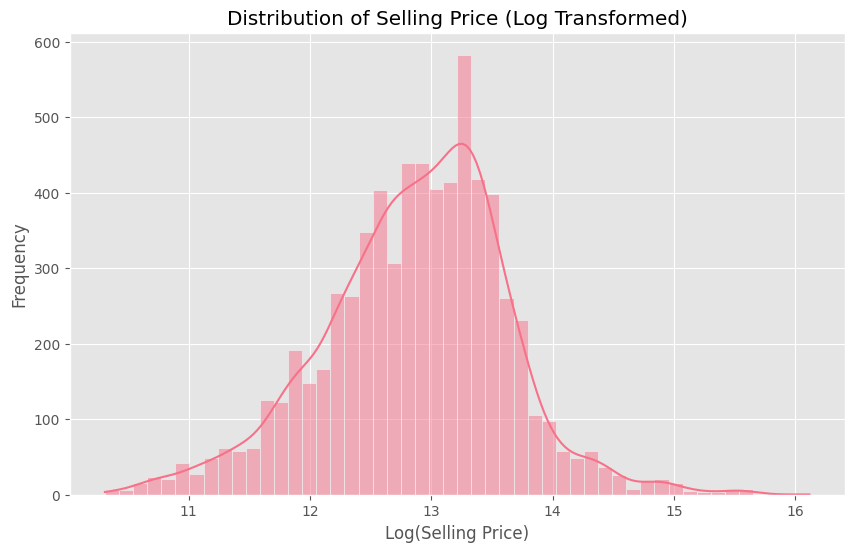

In [39]:
# Visualize the distribution of selling price (log transformed)
plt.figure(figsize=(10, 6))
sns.histplot(data['selling_price'], bins=50, kde=True)
plt.title("Distribution of Selling Price (Log Transformed)")
plt.xlabel("Log(Selling Price)")
plt.ylabel("Frequency")
plt.show()

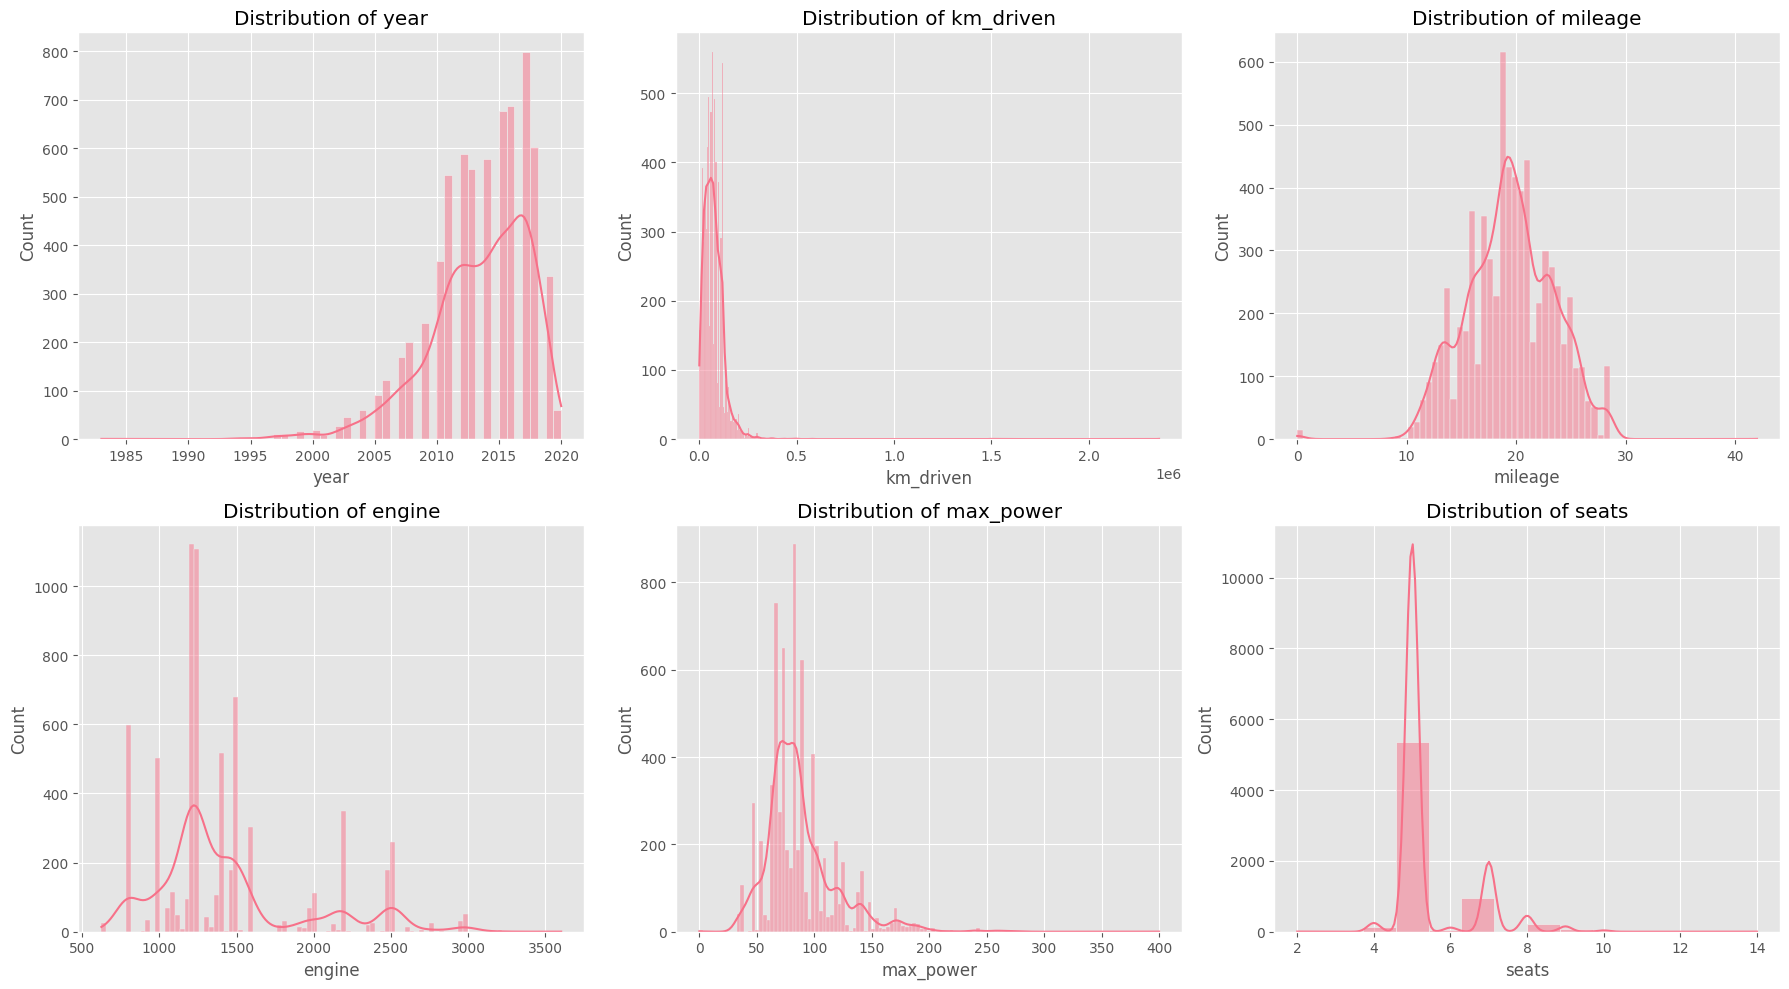

In [40]:
# Visualize numerical features
num_cols = ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'seats']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, col in enumerate(num_cols):
    sns.histplot(data[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    
plt.tight_layout()
plt.show()

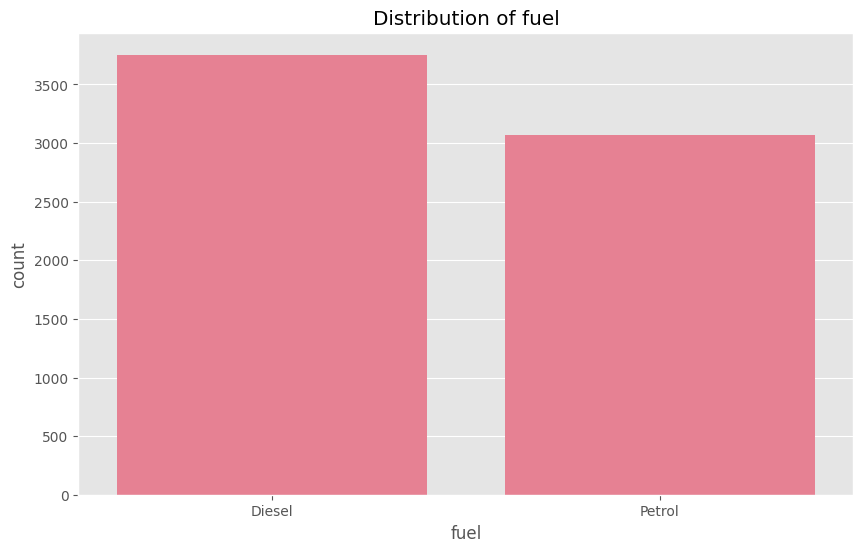

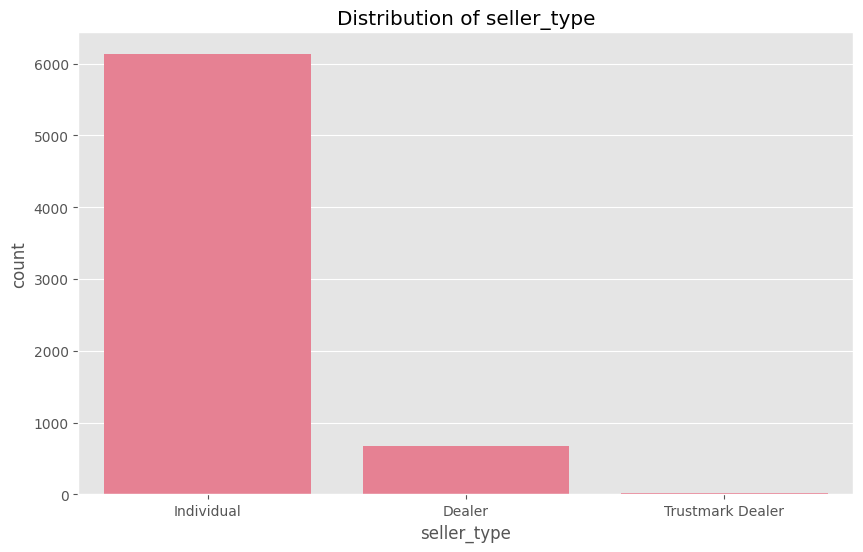

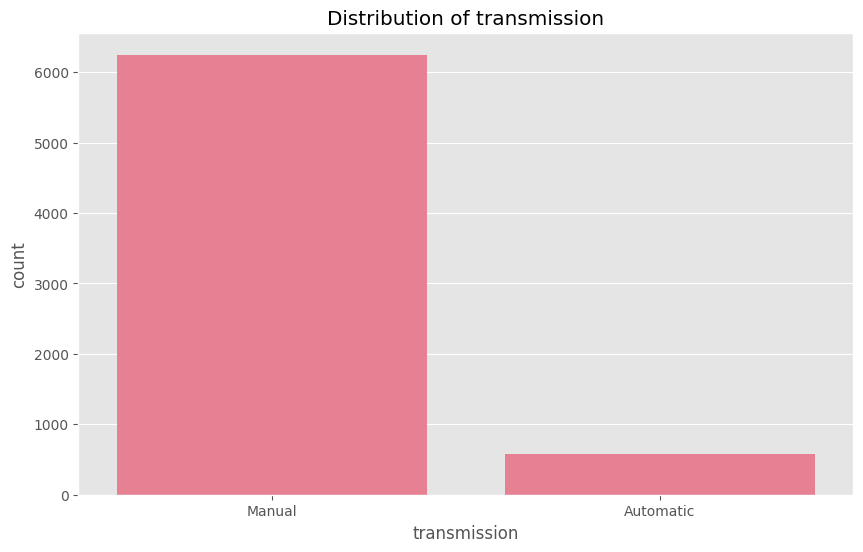

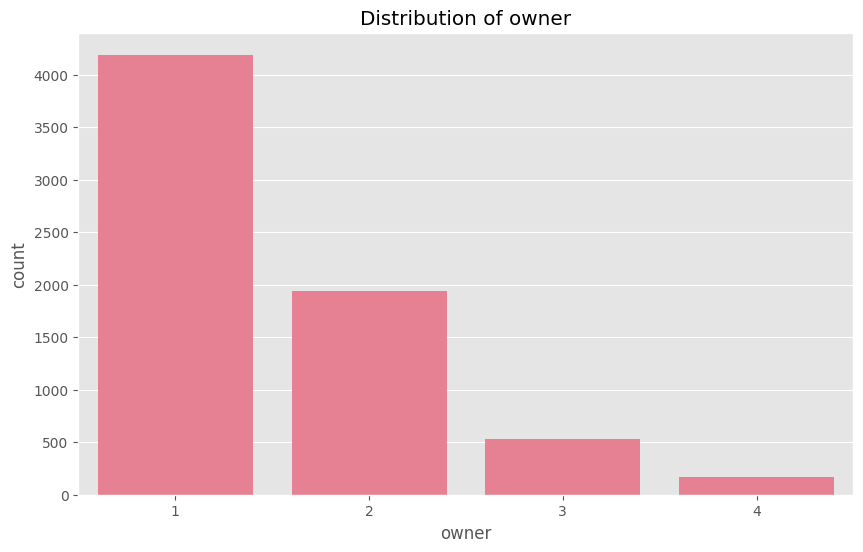

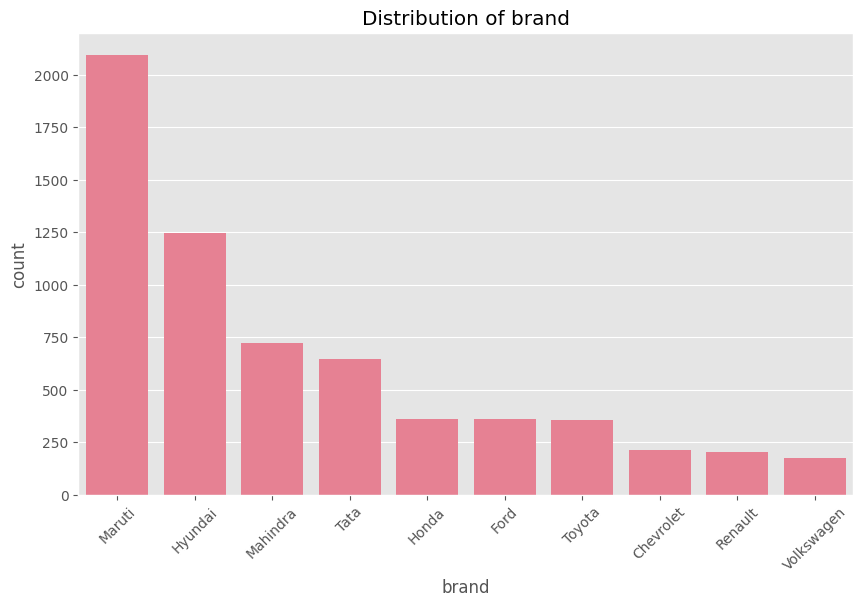

In [41]:
# Visualize categorical features
cat_cols = ['fuel', 'seller_type', 'transmission', 'owner', 'brand']

for col in cat_cols:
    plt.figure(figsize=(10, 6))
    if col == 'brand':  # For brand, show only top 10
        top_brands = data['brand'].value_counts().nlargest(10).index
        sns.countplot(data=data[data['brand'].isin(top_brands)], x=col, order=top_brands)
        plt.xticks(rotation=45)
    else:
        sns.countplot(data=data, x=col)
    plt.title(f"Distribution of {col}")
    plt.show()

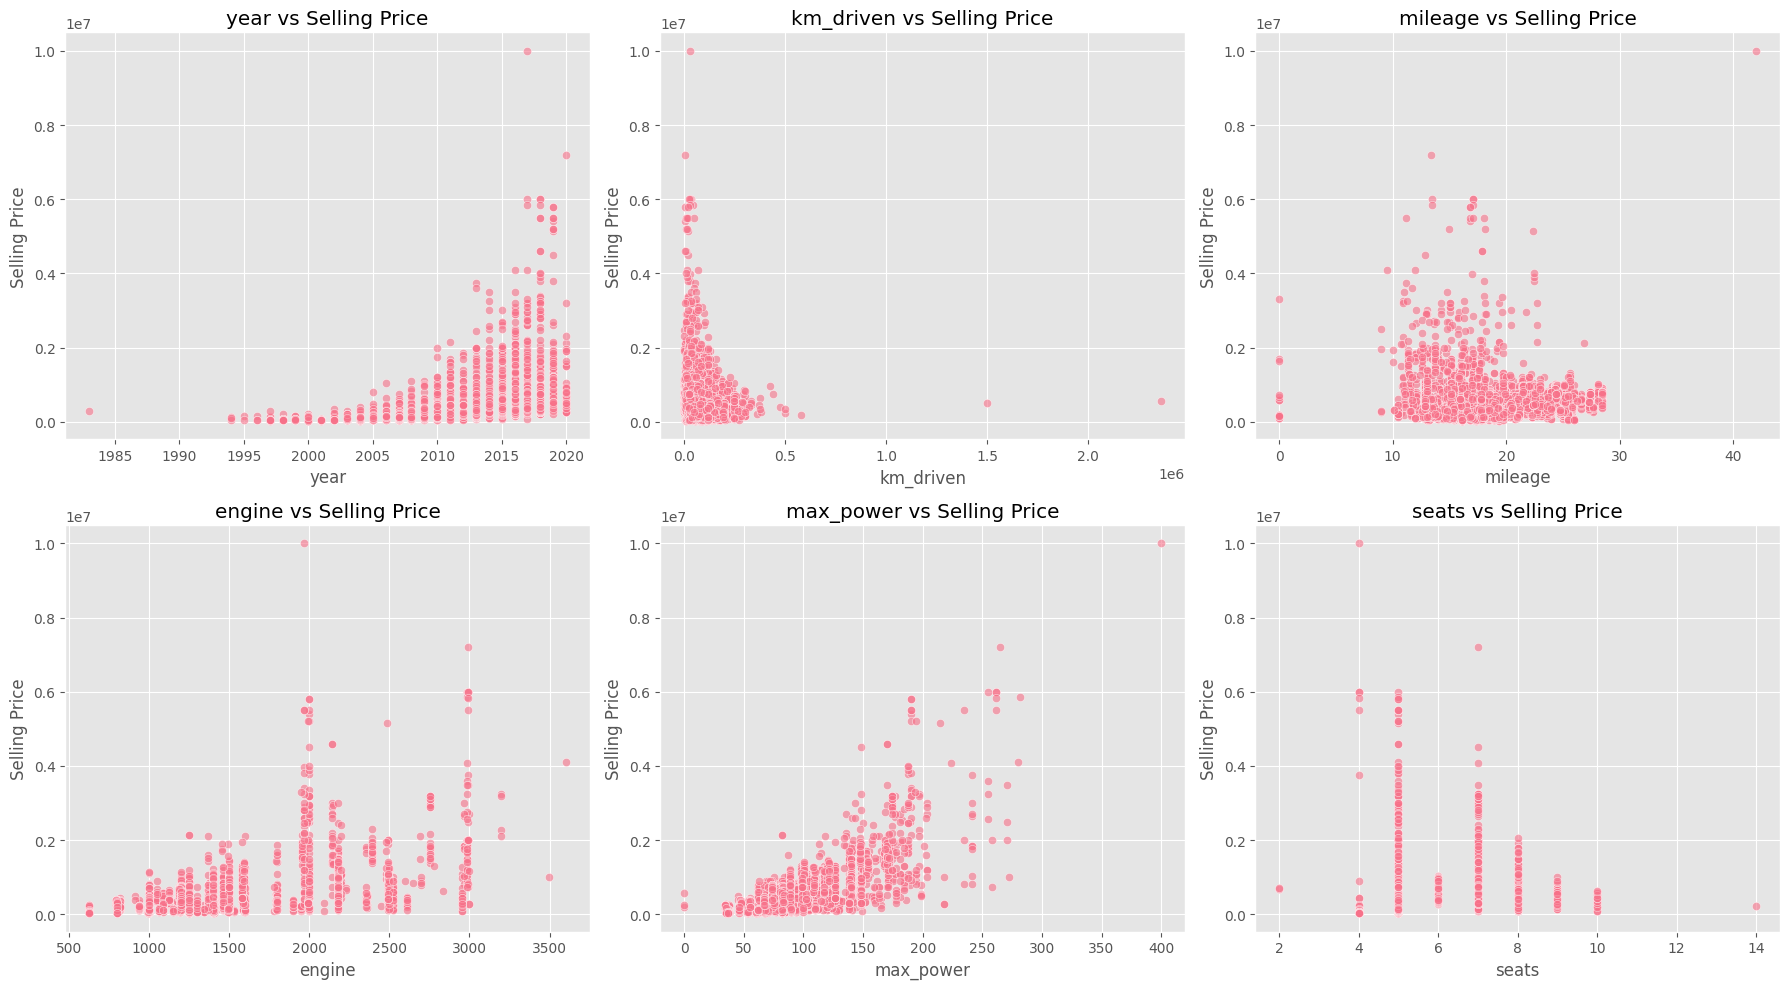

In [42]:
# Analyze relationship between features and selling price
# Numerical features vs selling price
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, col in enumerate(num_cols):
    sns.scatterplot(data=data, x=col, y=np.exp(data['selling_price']), ax=axes[i], alpha=0.6)
    axes[i].set_title(f"{col} vs Selling Price")
    axes[i].set_ylabel("Selling Price")
    
plt.tight_layout()
plt.show()

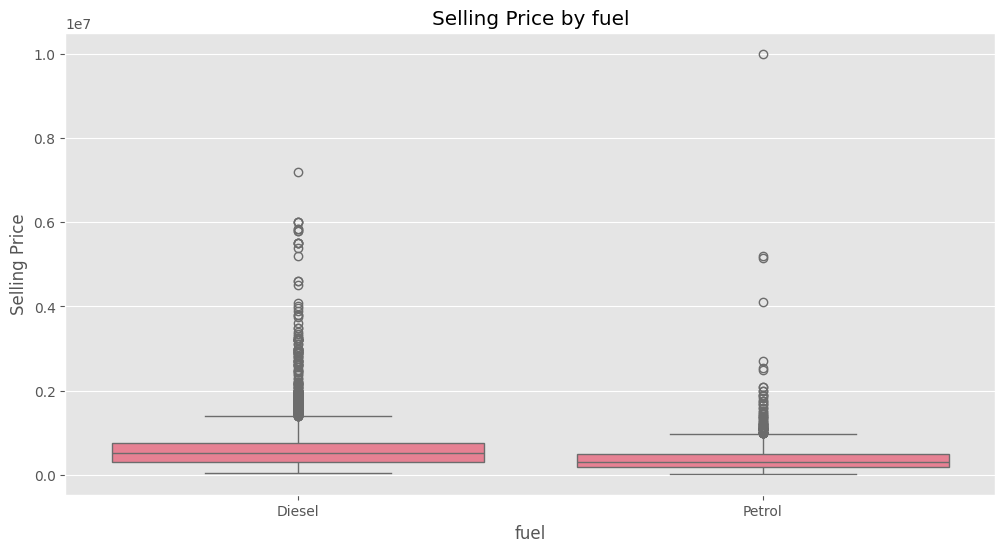

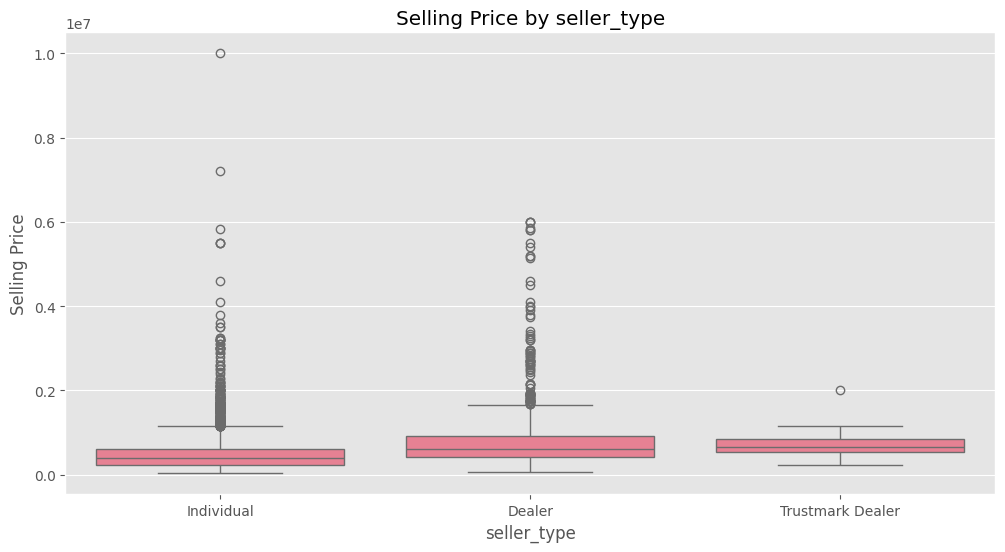

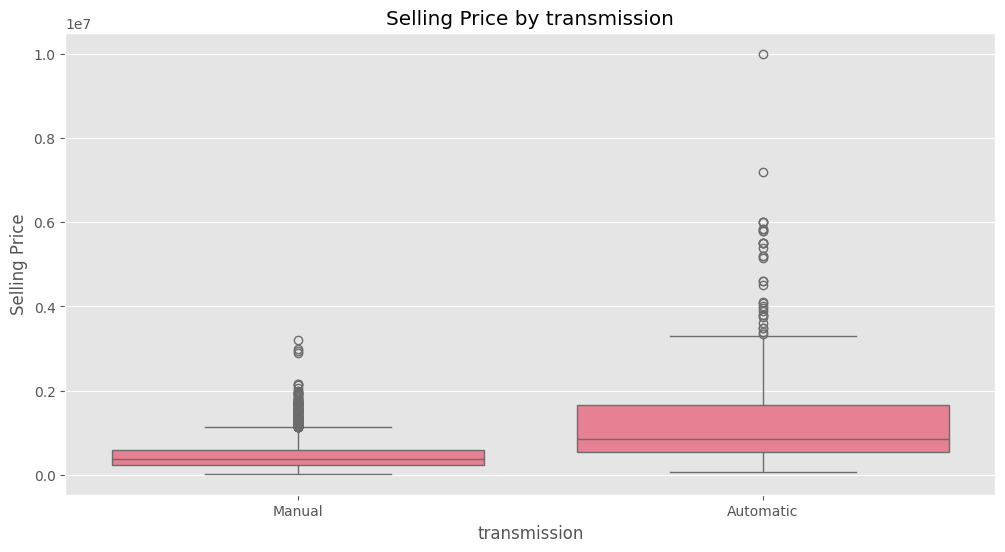

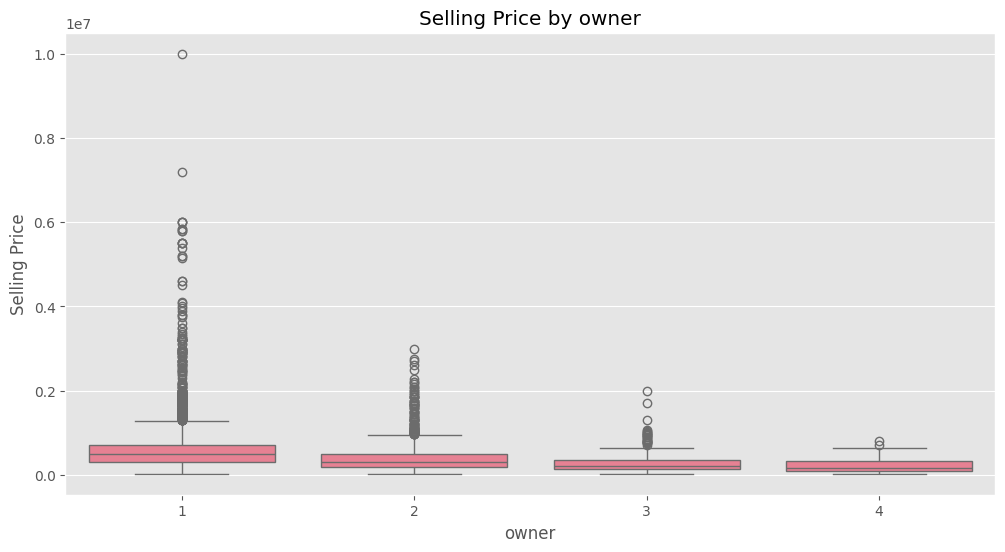

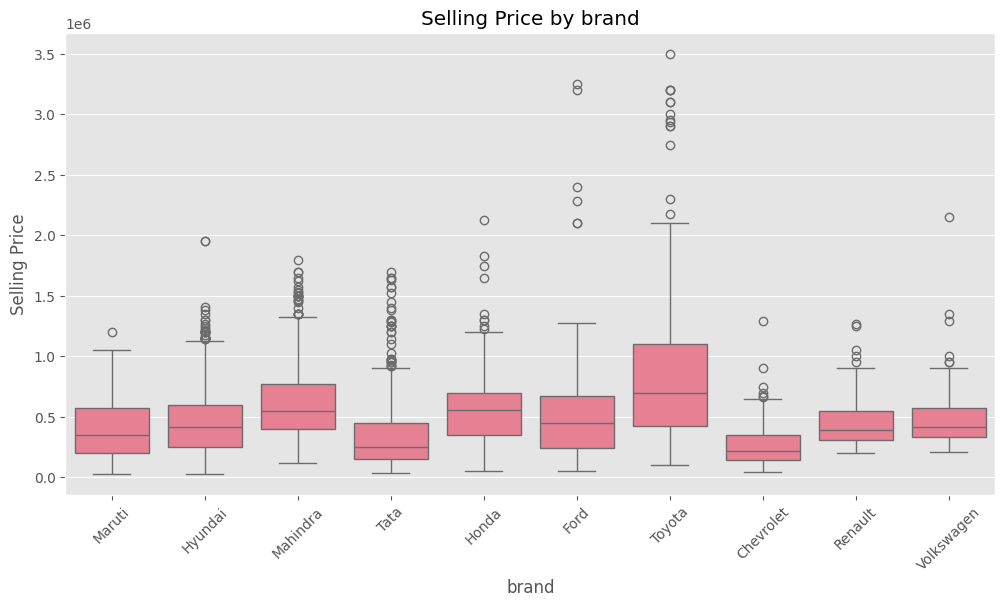

In [43]:
# Categorical features vs selling price
for col in cat_cols:
    plt.figure(figsize=(12, 6))
    if col == 'brand':  # For brand, show only top 10
        top_brands = data['brand'].value_counts().nlargest(10).index
        sns.boxplot(data=data[data['brand'].isin(top_brands)], x=col, y=np.exp(data['selling_price']), order=top_brands)
        plt.xticks(rotation=45)
    else:
        sns.boxplot(data=data, x=col, y=np.exp(data['selling_price']))
    plt.title(f"Selling Price by {col}")
    plt.ylabel("Selling Price")
    plt.show()

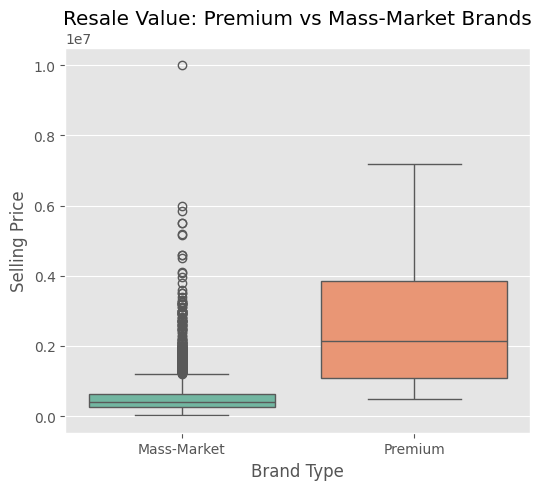

In [44]:
# Focus only on premium vs non-premium
data["brand_type"] = data["brand"].apply(lambda x: "Premium" if x in ["BMW", "Mercedes"] else "Mass-Market")

plt.figure(figsize=(6, 5))
sns.boxplot(
    data=data,
    x="brand_type",
    y=np.exp(data["selling_price"]),
    palette="Set2"
)

plt.title("Resale Value: Premium vs Mass-Market Brands")
plt.ylabel("Selling Price")
plt.xlabel("Brand Type")
plt.show()


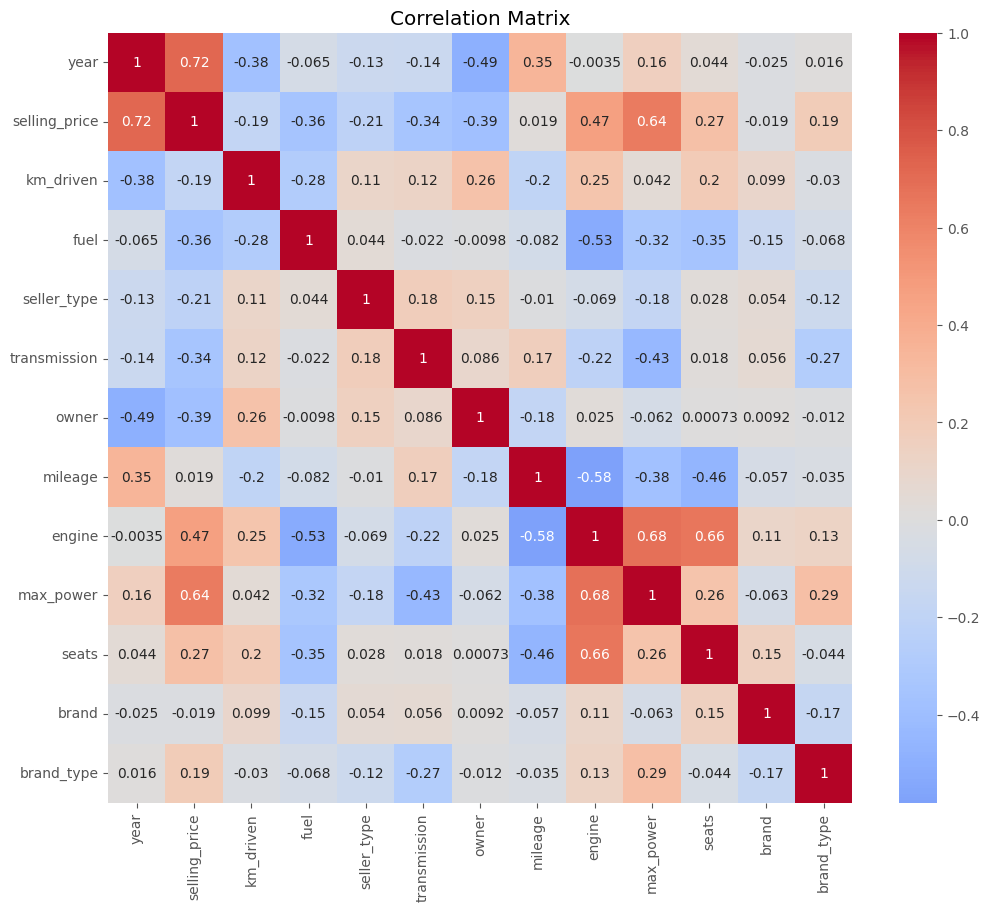

In [45]:
# Correlation analysis
from sklearn.preprocessing import LabelEncoder
# Create a copy for correlation analysis
corr_data = data.copy()

# Encode categorical variables
cat_cols = corr_data.select_dtypes(exclude='number').columns
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    corr_data[col] = le.fit_transform(corr_data[col].astype(str))
    le_dict[col] = le

# Calculate correlation matrix
corr_matrix = corr_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

In [46]:
# Correlation with target
corr_with_target = corr_matrix['selling_price'].drop('selling_price')
corr_sorted = corr_with_target.reindex(corr_with_target.abs().sort_values(ascending=False).index)

print("Feature correlations with selling price:")
print(corr_sorted)

Feature correlations with selling price:
year            0.718678
max_power       0.637513
engine          0.468379
owner          -0.389101
fuel           -0.356654
transmission   -0.343871
seats           0.273511
seller_type    -0.212444
brand_type      0.188333
km_driven      -0.185280
mileage         0.018881
brand          -0.018835
Name: selling_price, dtype: float64


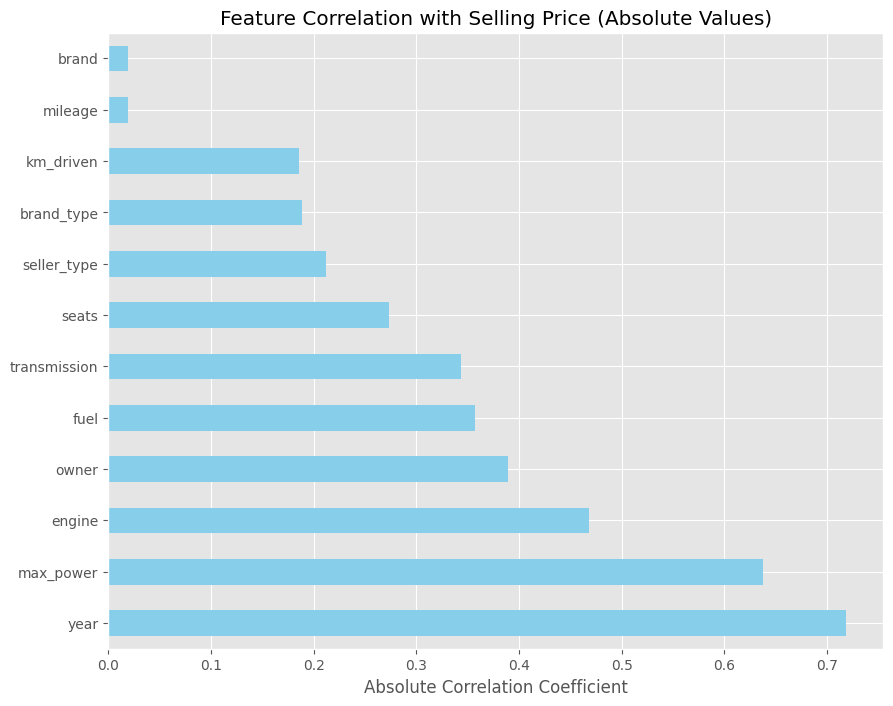

In [47]:
# Plot feature importance based on correlation
plt.figure(figsize=(10, 8))
corr_sorted.abs().plot(kind='barh', color='skyblue')
plt.title("Feature Correlation with Selling Price (Absolute Values)")
plt.xlabel("Absolute Correlation Coefficient")
plt.show()


In [48]:
# Prepare features and target for modeling
feature_cols = ['year', 'max_power', 'engine', 'brand', 'km_driven','mileage']
X = data[feature_cols]
y = data["selling_price"]

In [49]:
# Encode brand column as others are already encoded
le = LabelEncoder()
X.loc[:, 'brand'] = le.fit_transform(X['brand'].astype(str))

In [50]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (5461, 6)
Testing set shape: (1366, 6)


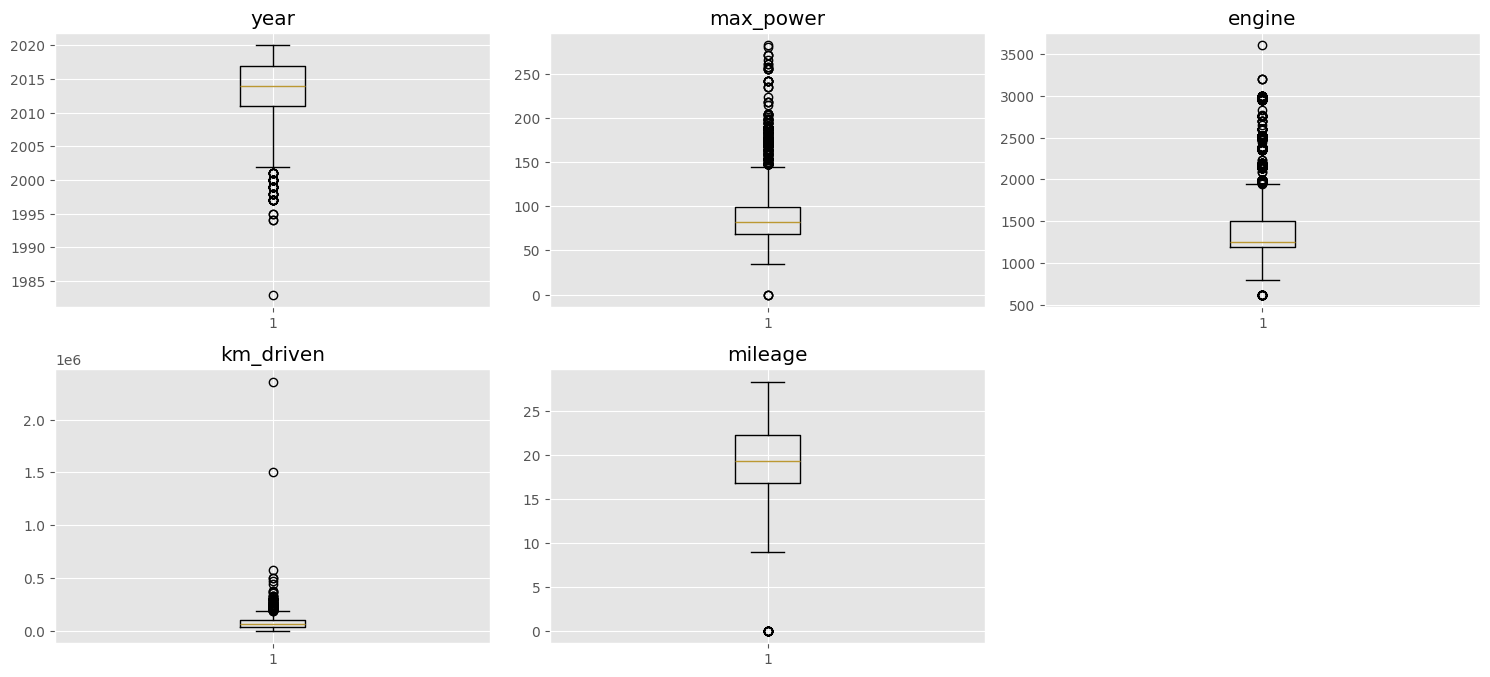

In [51]:
# Check for outliers in numerical features
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i+1)
    plt.boxplot(X_train[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [52]:
# Define function to count outliers
def outlier_count(col, data=X_train):
    q75, q25 = np.percentile(data[col], [75, 25])
    iqr = q75 - q25
    min_val = q25 - (iqr * 1.5)
    max_val = q75 + (iqr * 1.5)
    outlier_count = len(np.where((data[col] > max_val) | (data[col] < min_val))[0])
    outlier_percent = round(outlier_count / len(data[col]) * 100, 2)
    
    if outlier_count > 0:
        print(f"{col}: {outlier_count} outliers ({outlier_percent}%)")

print("Outlier analysis:")
for col in num_cols:
    outlier_count(col)

Outlier analysis:
year: 61 outliers (1.12%)
max_power: 307 outliers (5.62%)
engine: 978 outliers (17.91%)
km_driven: 138 outliers (2.53%)
mileage: 15 outliers (0.27%)


In [53]:
# from sklearn.preprocessing import MinMaxScaler

# # --- Scale only X ---
# X_train = X_train[feature_cols]
# X_test  = X_test[feature_cols]

# scaler_X = MinMaxScaler()
# X_train = pd.DataFrame(scaler_X.fit_transform(X_train), columns=feature_cols)
# X_test  = pd.DataFrame(scaler_X.transform(X_test), columns=feature_cols)

# # y can remain as Series
# y_train = y_train
# y_test  = y_test

In [54]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5461, 6), (5461,), (1366, 6), (1366,))

<H1>LINEAR REGRESSION</H1>

In [55]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import KFold
import mlflow

class LinearRegression:
    def __init__(self,
                 lr=0.001,
                 num_epochs=500,
                 batch_size=50,
                 method='batch',
                 init_method='zeros',
                 use_momentum=False,
                 momentum=0.9,
                 polynomial=False,
                 degree=2,
                 regularization=None,
                 kfold_splits=3,
                 random_state=42):
        
        # Training params
        self.lr = lr
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.method = method
        self.init_method = init_method.lower()
        self.use_momentum = use_momentum
        self.momentum = momentum
        self.velocity = None
        self.regularization = regularization
        
        # Polynomial
        self.polynomial = polynomial
        self.degree = degree
        self.poly_transformer = None
        
        # Scaling and encoding
        self.scaler = None
        self.label_encoders = {}
        self.categorical_cols = []
        self.feature_cols = None
        
        # KFold
        self.kfold = KFold(n_splits=kfold_splits, shuffle=True, random_state=random_state)
        self.kfold_scores = []

    # ---------------- Metrics ----------------
    def mse(self, ytrue, ypred):
        return np.mean((ypred - ytrue)**2)

    def r2(self, ytrue, ypred):
        ss_res = np.sum((ytrue - ypred)**2)
        ss_tot = np.sum((ytrue - np.mean(ytrue))**2)
        return 1 - (ss_res / ss_tot)

    # ---------------- Weight Initialization ----------------
    def _initialize_weights(self, n_features):
        if self.init_method == 'xavier':
            limit = np.sqrt(1 / n_features)
            return np.random.uniform(-limit, limit, size=n_features)
        else:
            return np.zeros(n_features)

    # ---------------- Preprocessing ----------------
    def _preprocess_X(self, X, fit=True):
        X = X.copy()
        # Identify numeric and categorical columns
        if self.feature_cols is None:
            self.feature_cols = X.columns.tolist()
        if not self.categorical_cols:
            self.categorical_cols = X.select_dtypes(include='object').columns.tolist()

        # Encode categorical columns
        for col in self.categorical_cols:
            if fit:
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))
                self.label_encoders[col] = le
            else:
                le = self.label_encoders.get(col)
                if le is None:
                    raise ValueError(f"LabelEncoder for {col} not found")
                # Handle unseen labels
                X[col] = X[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else 0)

        # Polynomial features
        X_poly = X.values
        if self.polynomial:
            if fit:
                poly = PolynomialFeatures(degree=self.degree, include_bias=False)
                X_poly = poly.fit_transform(X_poly)
                self.poly_transformer = poly
            else:
                if self.poly_transformer is None:
                    raise ValueError("Polynomial transformer not fitted")
                X_poly = self.poly_transformer.transform(X_poly)

        # Scaling
        if fit:
            self.scaler = MinMaxScaler()
            X_poly = self.scaler.fit_transform(X_poly)
        else:
            if self.scaler is None:
                raise ValueError("Scaler not fitted")
            X_poly = self.scaler.transform(X_poly)

        # Add bias
        X_poly = np.c_[np.ones(X_poly.shape[0]), X_poly]
        return X_poly

    # ---------------- Train Step ----------------
    def _train_step(self, X, y):
        yhat = X @ self.theta
        grad = (X.T @ (yhat - y)) / X.shape[0]
        if self.regularization is not None:
            grad += self.regularization.derivation(self.theta)
        if self.use_momentum:
            self.velocity = self.momentum * self.velocity + self.lr * grad
            self.theta -= self.velocity
        else:
            self.theta -= self.lr * grad
        return self.mse(y, yhat)

    # ---------------- Fit ----------------
    def fit(self, X_train, y_train):
        self.kfold_scores = []
        self.val_loss_old = np.inf

        for fold, (train_idx, val_idx) in enumerate(self.kfold.split(X_train)):
            X_fold_train = X_train.iloc[train_idx]
            y_fold_train = y_train.iloc[train_idx]
            X_fold_val = X_train.iloc[val_idx]
            y_fold_val = y_train.iloc[val_idx]

            # Preprocess
            X_fold_train_proc = self._preprocess_X(X_fold_train, fit=True)
            X_fold_val_proc = self._preprocess_X(X_fold_val, fit=False)
            
            self.theta = self._initialize_weights(X_fold_train_proc.shape[1])
            if self.use_momentum:
                self.velocity = np.zeros_like(self.theta)

            # Log fold
            mlflow.log_params({
                f"fold{fold}_lr": self.lr,
                f"fold{fold}_init_method": self.init_method,
                f"fold{fold}_use_momentum": self.use_momentum,
                f"fold{fold}_momentum": self.momentum,
                f"fold{fold}_polynomial": self.polynomial,
                f"fold{fold}_degree": self.degree
            })

            for epoch in range(self.num_epochs):
                perm = np.random.permutation(X_fold_train_proc.shape[0])
                X_shuffled = X_fold_train_proc[perm]
                y_shuffled = y_fold_train.to_numpy()[perm] if hasattr(y_fold_train, "to_numpy") else y_fold_train[perm]

                # Train step
                if self.method == 'sto':
                    for i in range(X_shuffled.shape[0]):
                        train_loss = self._train_step(X_shuffled[i].reshape(1, -1), y_shuffled[i])
                elif self.method == 'mini':
                    for i in range(0, X_shuffled.shape[0], self.batch_size):
                        X_batch = X_shuffled[i:i+self.batch_size]
                        y_batch = y_shuffled[i:i+self.batch_size]
                        train_loss = self._train_step(X_batch, y_batch)
                else:
                    train_loss = self._train_step(X_shuffled, y_shuffled)

                val_loss = self.mse(X_fold_val_proc @ self.theta, y_fold_val.to_numpy())
                if np.allclose(val_loss, self.val_loss_old):
                    break
                self.val_loss_old = val_loss

            self.kfold_scores.append(val_loss)
            print(f"Fold {fold}: {val_loss}")

    # ---------------- Predict ----------------
    def predict(self, X):
        X_proc = self._preprocess_X(X, fit=False)
        return X_proc @ self.theta

    # ---------------- Coefficients ----------------
    def coef_(self):
        return self.theta[1:]

    def intercept_(self):
        return self.theta[0]


In [56]:
class LassoPenalty:
    
    def __init__(self, l):
        self.l = l # lambda value
        
    def __call__(self, theta): #__call__ allows us to call class as method
        return self.l * np.sum(np.abs(theta))
        
    def derivation(self, theta):
        return self.l * np.sign(theta)
    
class RidgePenalty:
    
    def __init__(self, l):
        self.l = l
        
    def __call__(self, theta): #__call__ allows us to call class as method
        return self.l * np.sum(np.square(theta))
        
    def derivation(self, theta):
        return self.l * 2 * theta
    
class ElasticPenalty:
    
    def __init__(self, l = 0.1, l_ratio = 0.5):
        self.l = l 
        self.l_ratio = l_ratio

    def __call__(self, theta):  #__call__ allows us to call class as method
        l1_contribution = self.l_ratio * self.l * np.sum(np.abs(theta))
        l2_contribution = (1 - self.l_ratio) * self.l * 0.5 * np.sum(np.square(theta))
        return (l1_contribution + l2_contribution)

    def derivation(self, theta):
        l1_derivation = self.l * self.l_ratio * np.sign(theta)
        l2_derivation = self.l * (1 - self.l_ratio) * theta
        return (l1_derivation + l2_derivation)
    
class Lasso(LinearRegression):
    
    def __init__(self, method, lr, l):
        self.regularization = LassoPenalty(l)
        super().__init__(self.regularization, lr, method)
        
class Ridge(LinearRegression):
    
    def __init__(self, method, lr, l):
        self.regularization = RidgePenalty(l)
        super().__init__(self.regularization, lr, method)
        
class ElasticNet(LinearRegression):
    
    def __init__(self, method, lr, l, l_ratio=0.5):
        self.regularization = ElasticPenalty(l, l_ratio)
        super().__init__(self.regularization, lr, method)


In [57]:
#helper function for looping classnames
import sys

def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def run_experiment(
    model_class, X_train, y_train, X_test, y_test,
    method='batch', lr=0.001, init_method='zeros',
    use_momentum=False, momentum=0.9,
    polynomial=False, degree=2,
    l=0.1, l_ratio=0.5,
    run_name="experiment"
):
    # Only LinearRegression for now
    model = LinearRegression(
        lr=lr, method=method, init_method=init_method,
        use_momentum=use_momentum, momentum=momentum,
        polynomial=polynomial, degree=degree,
    )

    # Top-level MLflow run
    with mlflow.start_run(run_name=run_name):
        # Fit model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Metrics
        mse_val = model.mse(y_test, y_pred)
        r2_val = model.r2(y_test, y_pred)
        print(f"Test MSE: {mse_val}, Test R2: {r2_val}")

        # Log main metrics & parameters
        mlflow.log_params({
            "model_class": model_class,
            "method": method,
            "lr": lr,
            "init_method": init_method,
            "use_momentum": use_momentum,
            "momentum": momentum,
            "polynomial": polynomial,
            "degree": degree
        })
        mlflow.log_metric("mse", mse_val)
        mlflow.log_metric("r2", r2_val)

        # Feature importance
        if polynomial and model.poly_transformer is not None:
            feature_names = ["bias"] + list(model.poly_transformer.get_feature_names_out(
                X_train.columns if hasattr(X_train, "columns") else [f"x{i+1}" for i in range(X_train.shape[1])]
            ))
        else:
            feature_names = ["bias"] + [f"x{i+1}" for i in range(X_train.shape[1])]

        # Feature importance
        fi = pd.Series(np.abs(model.theta), index=feature_names).sort_values(ascending=False)
        plt.figure(figsize=(8,5))
        sns.barplot(x=fi.values, y=fi.index)
        plt.title("Feature Importance")
        plt.xlabel("Absolute Coefficient Value")
        plt.tight_layout()
        mlflow.log_figure(plt.gcf(), "feature_importance.png")  # log first
        plt.show()
        plt.close()

        # Actual vs Predicted
        plt.figure(figsize=(6,6))
        plt.scatter(y_test, y_pred, alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title("Actual vs Predicted")
        plt.tight_layout()
        mlflow.log_figure(plt.gcf(), "actual_vs_predicted.png")
        plt.show()
        plt.close()

        # Residuals vs Predicted
        residuals = y_test - y_pred
        plt.figure(figsize=(6,4))
        plt.scatter(y_pred, residuals, alpha=0.7)
        plt.hlines(0, y_pred.min(), y_pred.max(), colors='r', linestyles='--')
        plt.xlabel("Predicted")
        plt.ylabel("Residuals")
        plt.title("Residuals vs Predicted")
        plt.tight_layout()
        mlflow.log_figure(plt.gcf(), "residuals_vs_predicted.png")
        plt.show()
        plt.close()

        return {"model": model, "mse": mse_val, "r2": r2_val}


In [59]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (5461, 6)
y_train shape: (5461,)



🚀 Running Model Class: Normal
Fold 0: 0.2029015540751323
Fold 1: 0.14610616656759326
Fold 2: 0.39978557300437195
Test MSE: 0.3917179923635782, Test R2: 0.2951306713477453


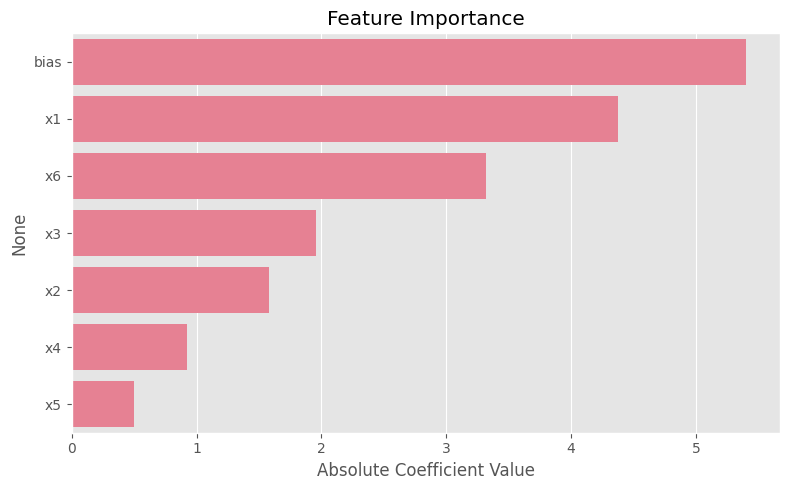

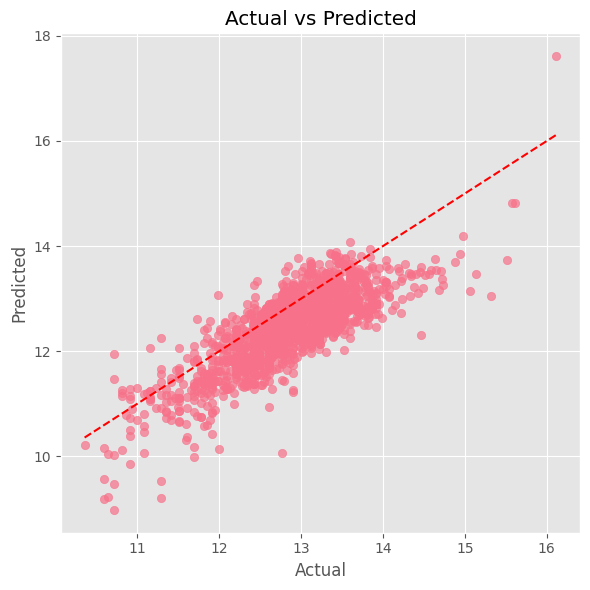

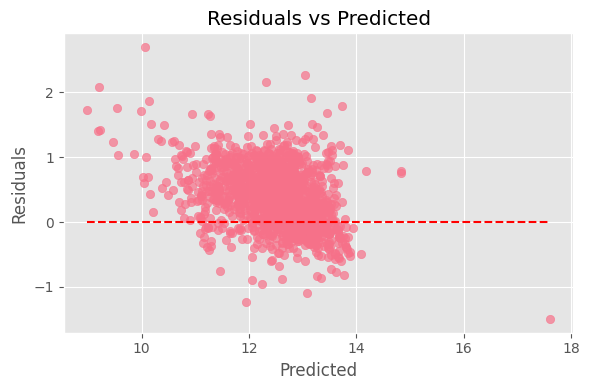

🏃 View run Normal_FullData at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/fd844578b19646dc86f1250712f96a34
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.391718, r2=0.295131

🚀 Running Model Class: Ridge
Fold 0: 0.2017599173283733
Fold 1: 0.13776317063021531
Fold 2: 0.1547761477266295
Test MSE: 0.16346296216381112, Test R2: 0.7058597494981249


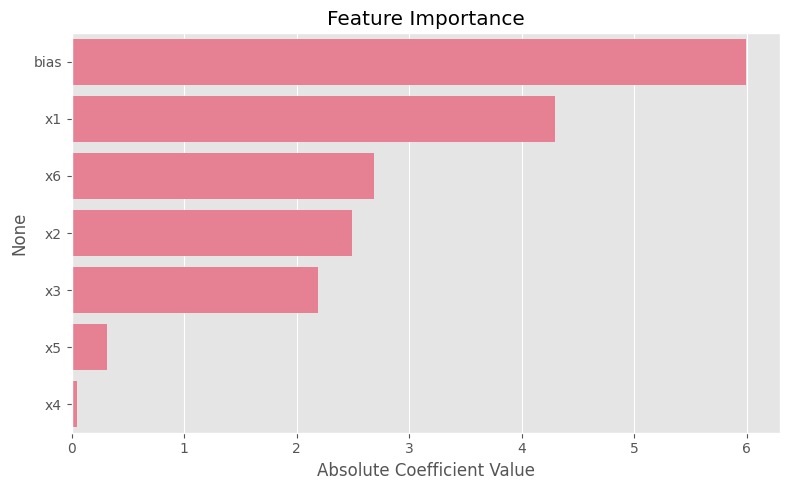

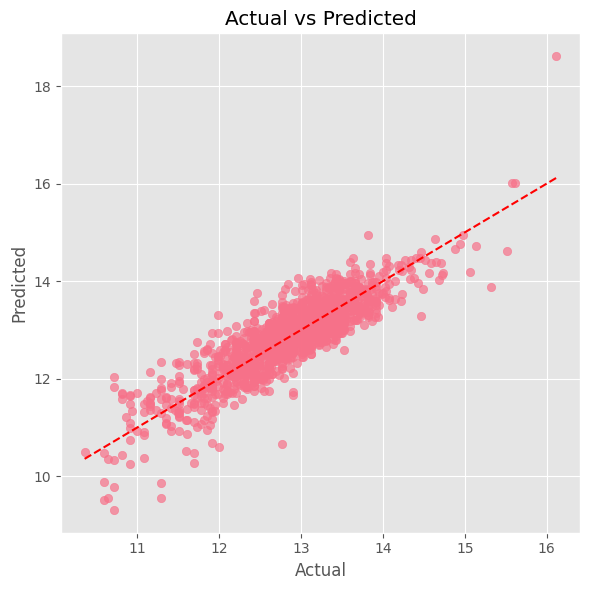

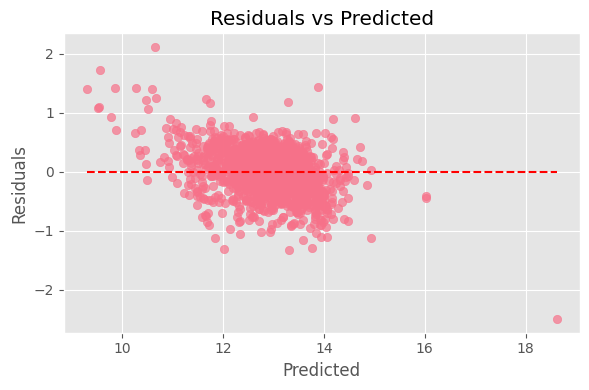

🏃 View run Ridge_FullData at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/85fee31cf6404215a2594aa6cc8c98f7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.163463, r2=0.705860

🚀 Running Model Class: Lasso
Fold 0: 0.20139057876711272
Fold 1: 0.13705382539412916
Fold 2: 0.14964080533940022
Test MSE: 0.152075794769003, Test R2: 0.7263501665667884


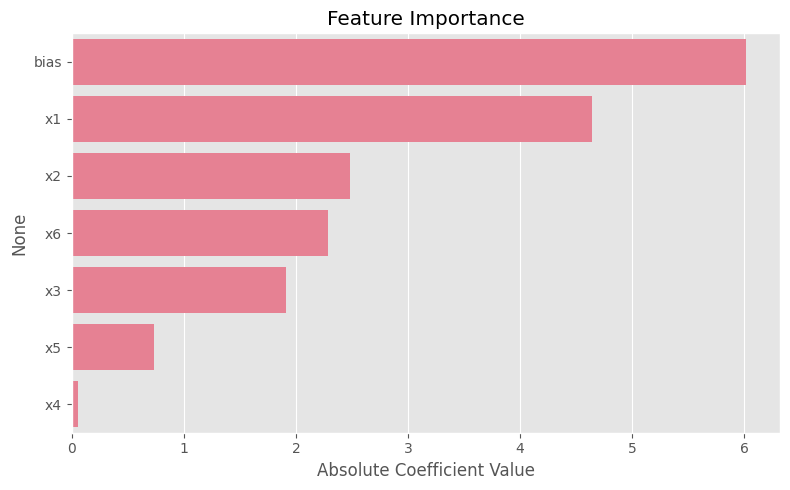

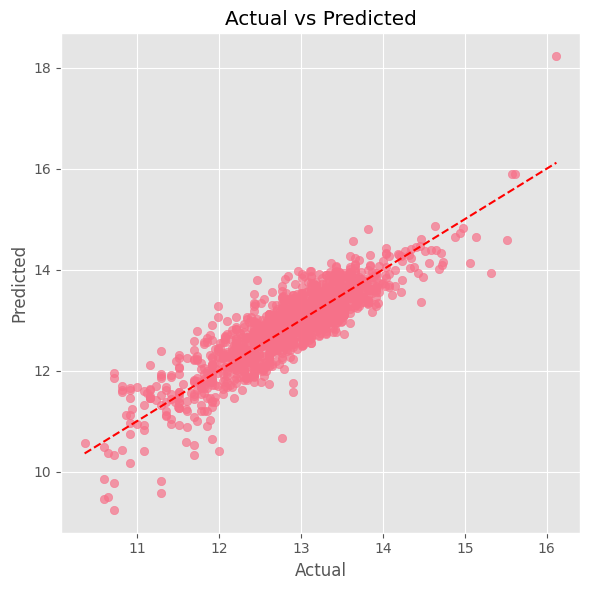

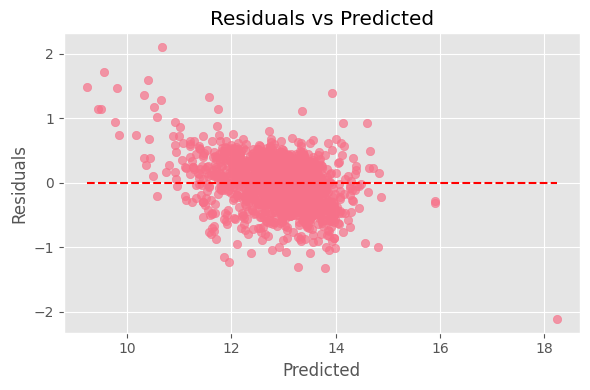

🏃 View run Lasso_FullData at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/5fb579bd73334df0b67b39251292a25a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.152076, r2=0.726350

🚀 Running Model Class: ElasticNet
Fold 0: 0.18530788337502493
Fold 1: 0.1347207842311778
Fold 2: 0.15810758110411904
Test MSE: 0.16650324640978556, Test R2: 0.7003889690970476


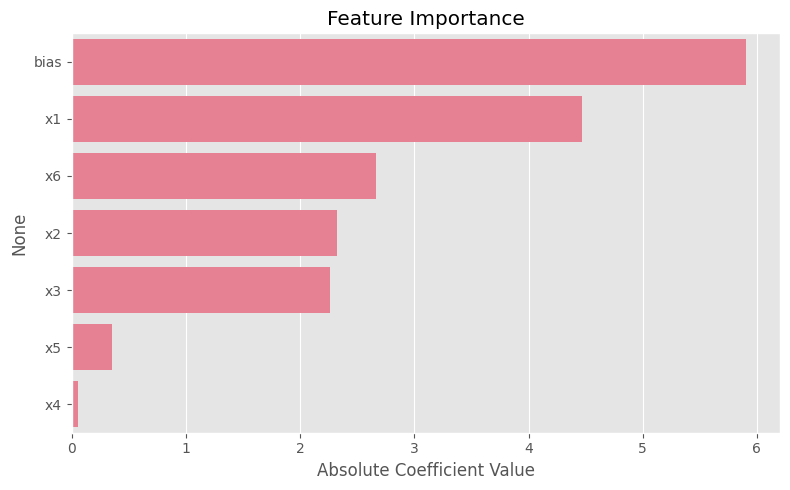

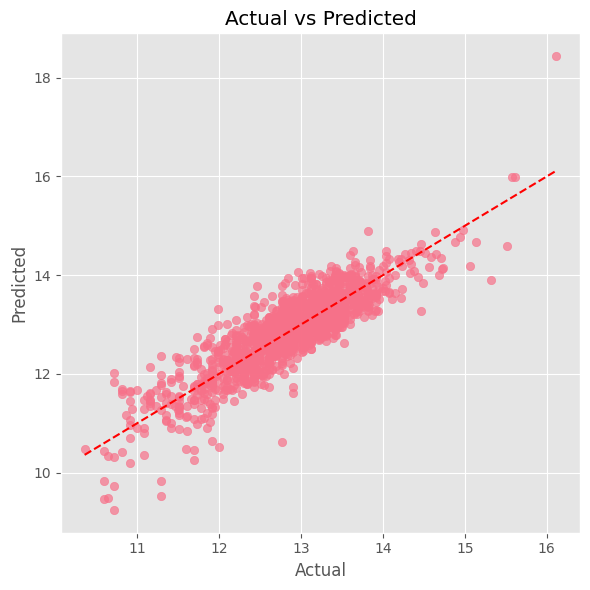

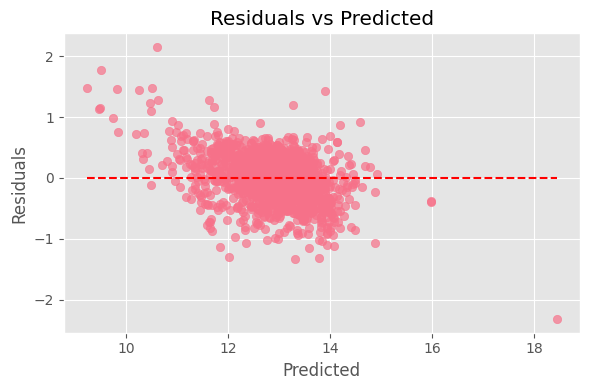

🏃 View run ElasticNet_FullData at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/f295797d7163441fbe167a9293858287
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.166503, r2=0.700389


,model_class,mse,r2
0,Lasso,0.152076,0.726350
1,Ridge,0.163463,0.705860
2,ElasticNet,0.166503,0.700389
3,Normal,0.391718,0.295131


In [60]:
import numpy as np
import pandas as pd
from copy import deepcopy
import mlflow

# -------------------------
# Comparison: Model classes
# -------------------------
model_classes = ["Normal", "Ridge", "Lasso", "ElasticNet"]
fixed_params = {
    "degree": 1,
    "method": "batch",
    "init_method": "xavier",
    "lr": 0.01,
    "use_momentum": True,
    "momentum": 0.9
}

results_classes = []

# Use deep copies to preserve original data
X_train_copy = deepcopy(X_train)
y_train_copy = deepcopy(y_train)
X_test_copy = deepcopy(X_test)
y_test_copy = deepcopy(y_test)

for model_class in model_classes:
    print(f"\n🚀 Running Model Class: {model_class}")

    try:
        # Run experiment once on full training and test data
        result = run_experiment(
            model_class=model_class,
            X_train=X_train_copy,
            y_train=y_train_copy,
            X_test=X_test_copy,
            y_test=y_test_copy,
            degree=fixed_params["degree"],
            method=fixed_params["method"],
            init_method=fixed_params["init_method"],
            lr=fixed_params["lr"],
            use_momentum=fixed_params["use_momentum"],
            run_name=f"{model_class}_FullData"
        )

        mse = result["mse"]
        r2 = result["r2"]
        print(f"mse={mse:.6f}, r2={r2:.6f}")

        results_classes.append({
            "model_class": model_class,
            "mse": mse,
            "r2": r2
        })

    except Exception as e:
        print(f"❌ Experiment failed for {model_class}: {e}")
        results_classes.append({
            "model_class": model_class,
            "mse": None,
            "r2": None
        })

# Final comparison table
df_classes = pd.DataFrame(results_classes).sort_values("r2", ascending=False)
df_classes.reset_index(drop=True, inplace=True)
df_classes



🚀 Running Ridge with use_momentum=True
Fold 0: 0.19126451575813266
Fold 1: 0.13379192819296035
Fold 2: 0.15074393976564412
Test MSE: 0.15802693826767572, Test R2: 0.7156414970535198


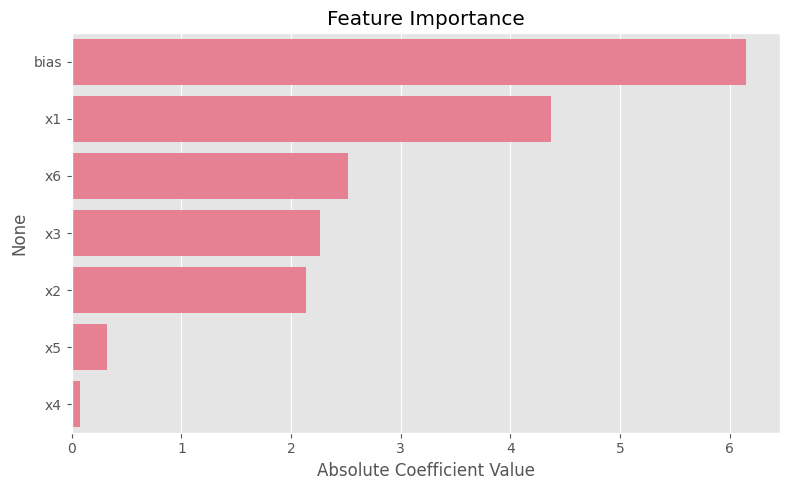

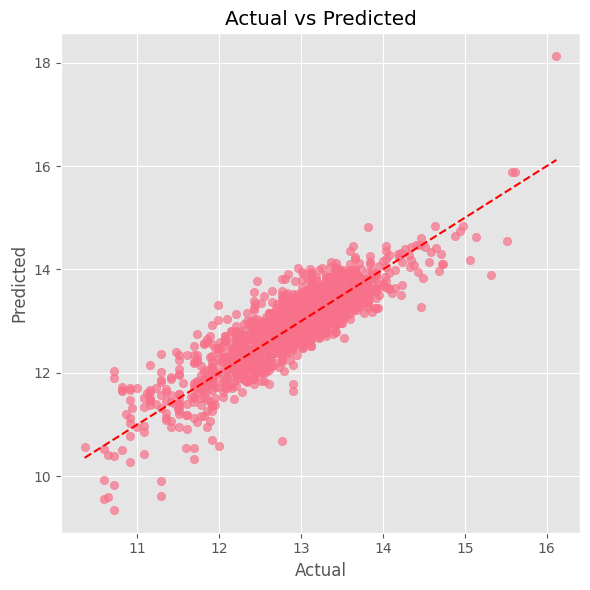

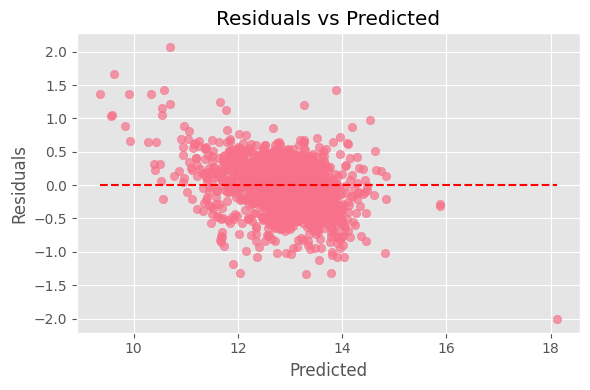

🏃 View run Ridge_Momentum_True at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/3b79a55e4e244ecea6c85dcb01c41672
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.158027, r2=0.715641

🚀 Running Ridge with use_momentum=False
Fold 0: 0.8705118087936838
Fold 1: 0.7314662499718003
Fold 2: 0.6905474885592087
Test MSE: 0.6779746962055929, Test R2: -0.21996839122492684


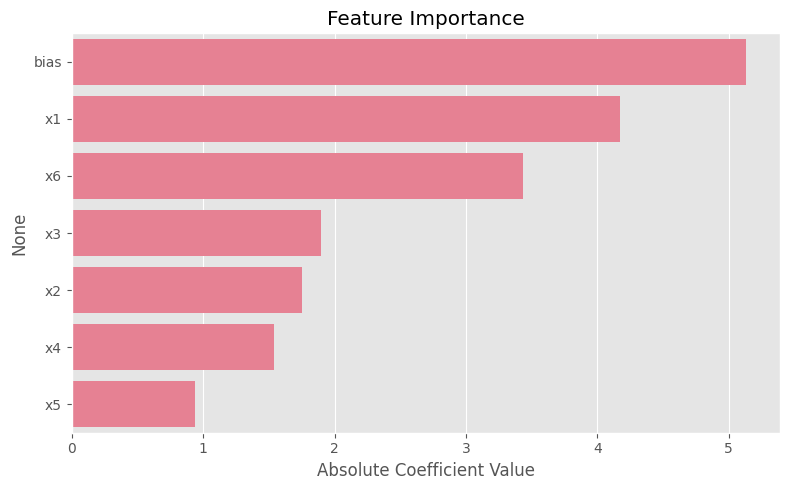

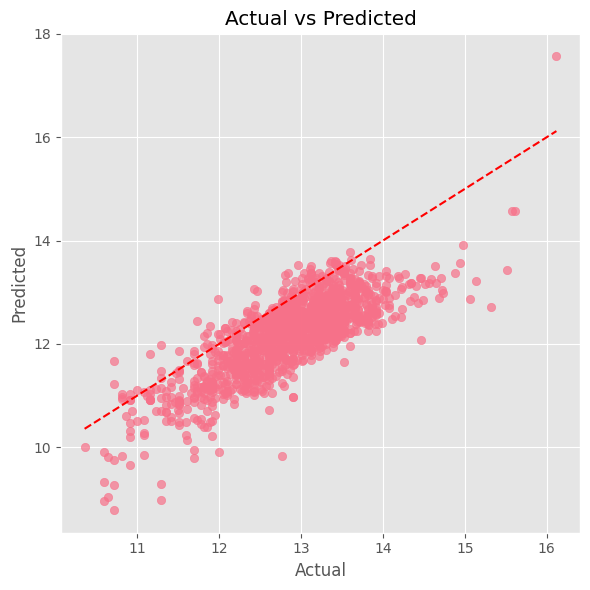

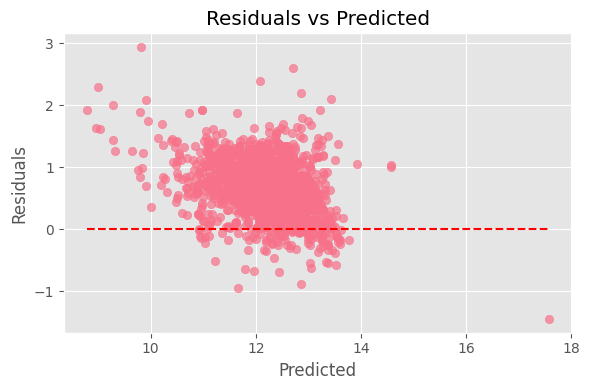

🏃 View run Ridge_Momentum_False at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/80894e6c21224887b668fc6596eab1d7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.677975, r2=-0.219968


,use_momentum,mse,r2
0,True,0.158027,0.715641
1,False,0.677975,-0.219968


In [61]:
import numpy as np
import pandas as pd
from copy import deepcopy
import mlflow

# -------------------------
# Comparison: Ridge + momentum
# -------------------------
momentum_options = [True, False]
fixed_params = {
    "degree": 1,
    "method": "batch",
    "init_method": "xavier",
    "lr": 0.01,
    "momentum": 0.9  # Only used if use_momentum=True
}

results_momentum = []

# Use deep copies to preserve original data
X_train_copy = deepcopy(X_train)
y_train_copy = deepcopy(y_train)
X_test_copy = deepcopy(X_test)
y_test_copy = deepcopy(y_test)

for use_momentum in momentum_options:
    print(f"\n🚀 Running Ridge with use_momentum={use_momentum}")

    try:
        # Run experiment once on full training and test data
        result = run_experiment(
            model_class="Ridge",
            X_train=X_train_copy,
            y_train=y_train_copy,
            X_test=X_test_copy,
            y_test=y_test_copy,
            degree=fixed_params["degree"],
            method=fixed_params["method"],
            init_method=fixed_params["init_method"],
            lr=fixed_params["lr"],
            use_momentum=use_momentum,
            momentum=fixed_params["momentum"],
            run_name=f"Ridge_Momentum_{use_momentum}"
        )

        mse = result["mse"]
        r2 = result["r2"]
        print(f"mse={mse:.6f}, r2={r2:.6f}")

        results_momentum.append({
            "use_momentum": use_momentum,
            "mse": mse,
            "r2": r2
        })

    except Exception as e:
        print(f"❌ Experiment failed for use_momentum={use_momentum}: {e}")
        results_momentum.append({
            "use_momentum": use_momentum,
            "mse": None,
            "r2": None
        })

# Final comparison table
df_momentum = pd.DataFrame(results_momentum).sort_values("r2", ascending=False)
df_momentum.reset_index(drop=True, inplace=True)
df_momentum


🚀 Running Ridge with method=sto
Fold 0: 0.11612307483370139
Fold 1: 0.11149838816012271
Fold 2: 0.11269295861282802
Test MSE: 0.10611527390700144, Test R2: 0.8090529326282413


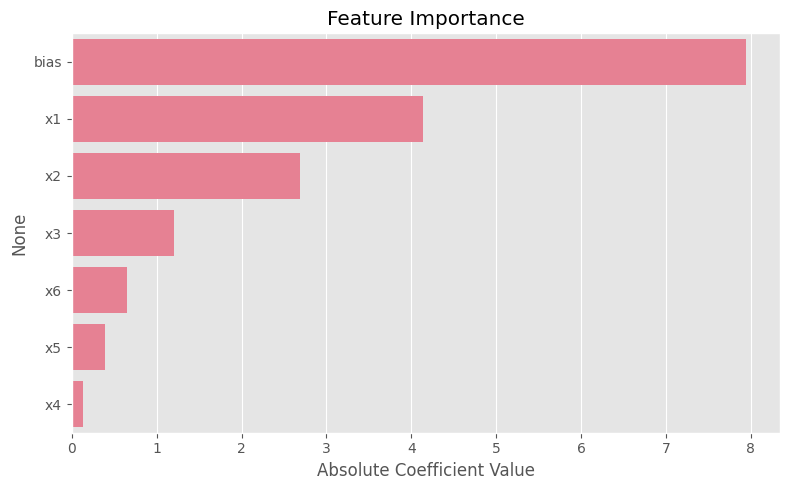

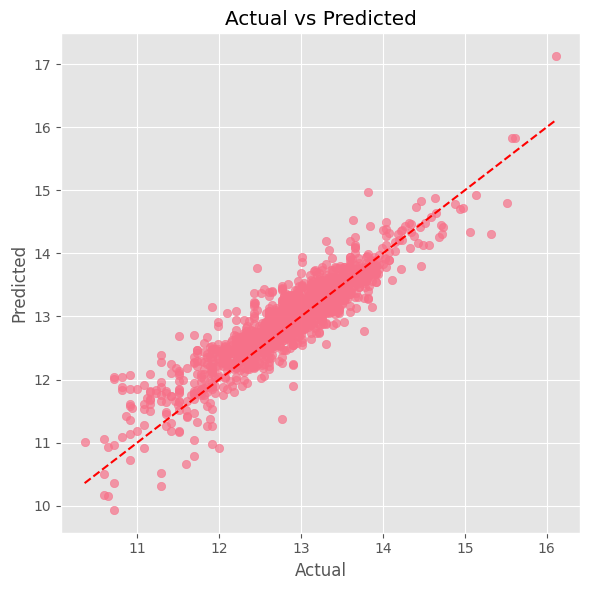

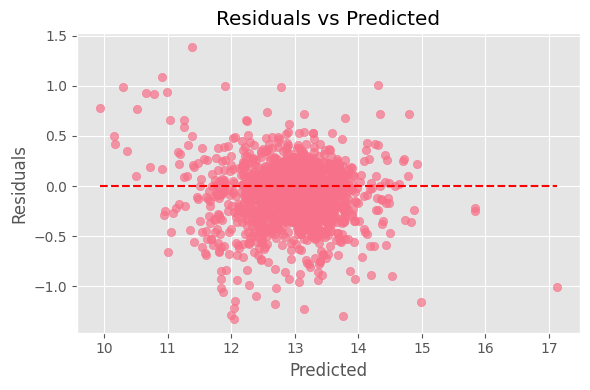

🏃 View run Ridge_Method_sto at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/adeed3a8edd9414a81fa52514b078379
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.106115, r2=0.809053

🚀 Running Ridge with method=mini
Fold 0: 0.12352025698048003
Fold 1: 0.1040454282929763
Fold 2: 0.10773336912442306
Test MSE: 0.10474486343298318, Test R2: 0.8115188911229502


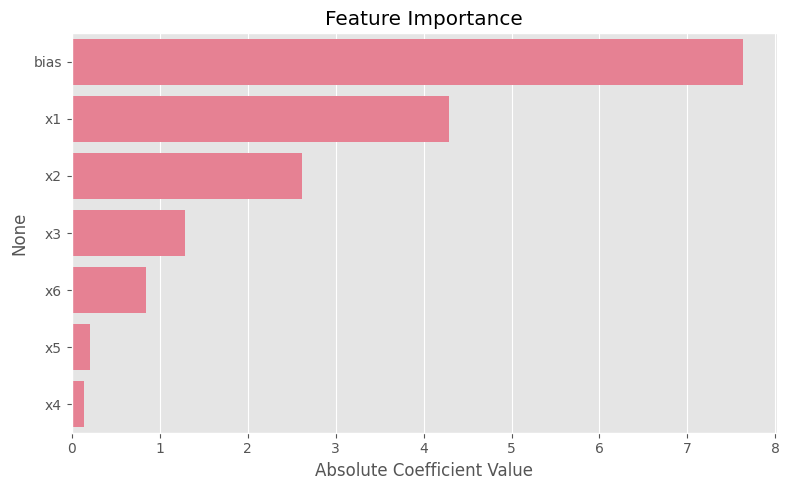

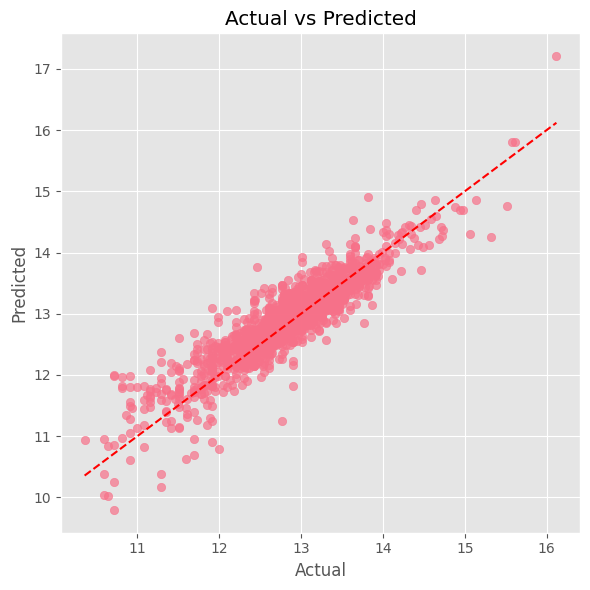

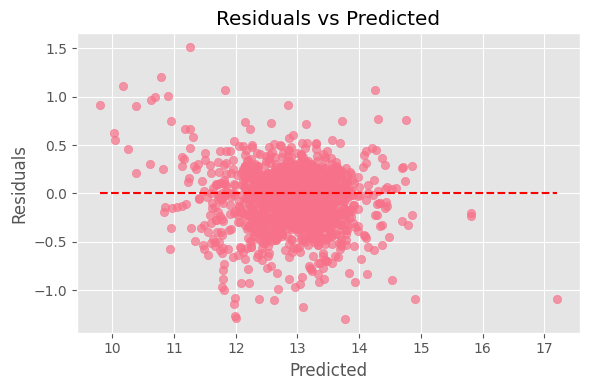

🏃 View run Ridge_Method_mini at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/70ab7db216fd48089ddcd3a0c0c3f8ea
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.104745, r2=0.811519

🚀 Running Ridge with method=batch
Fold 0: 0.9543720515645594
Fold 1: 0.6377675961273911
Fold 2: 0.7402603085416665
Test MSE: 0.7293378741748459, Test R2: -0.31239286362197216


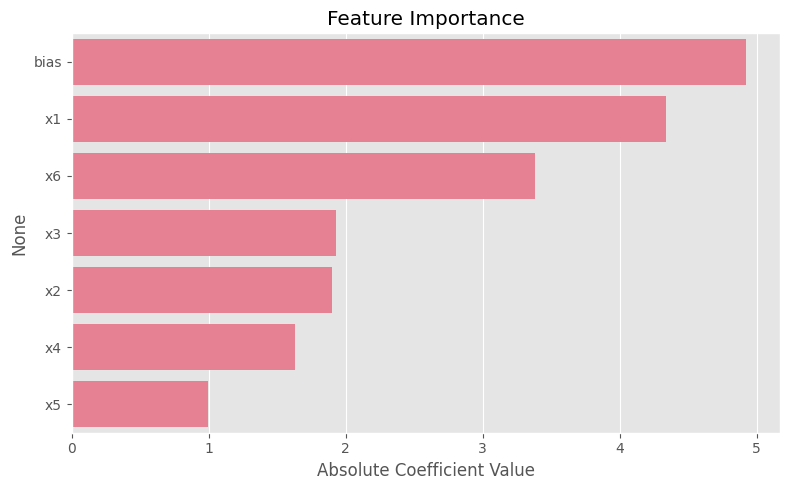

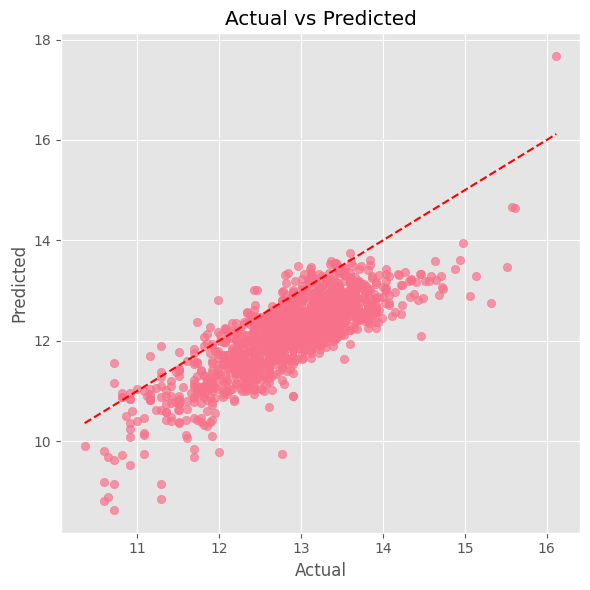

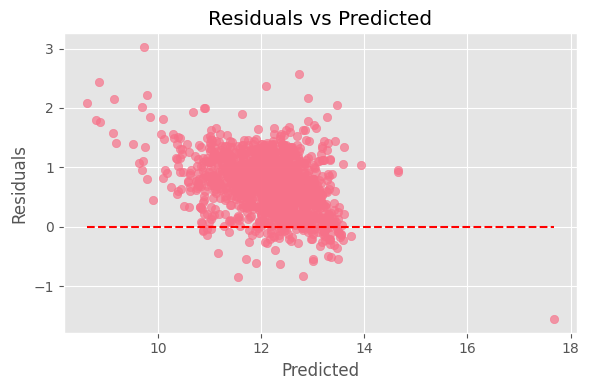

🏃 View run Ridge_Method_batch at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/aa5f1af366784f78b07a9e84557cae0a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.729338, r2=-0.312393


,method,mse,r2
0,mini,0.104745,0.811519
1,sto,0.106115,0.809053
2,batch,0.729338,-0.312393


In [62]:
import numpy as np
import pandas as pd
from copy import deepcopy
import mlflow

# -------------------------
# Comparison: Ridge with different optimization methods
# -------------------------
methods = ["sto", "mini", "batch"]
fixed_params = {
    "degree": 1,
    "init_method": "xavier",
    "lr": 0.01,
    "use_momentum": False,
    "momentum": 0.9,  # ignored since use_momentum=False
    "batch_size": 50
}

results_methods = []

# Use deep copies to preserve original data
X_train_copy = deepcopy(X_train)
y_train_copy = deepcopy(y_train)
X_test_copy = deepcopy(X_test)
y_test_copy = deepcopy(y_test)

for method in methods:
    print(f"\n🚀 Running Ridge with method={method}")

    try:
        # Run experiment once on full training and test data
        result = run_experiment(
            model_class="Ridge",
            X_train=X_train_copy,
            y_train=y_train_copy,
            X_test=X_test_copy,
            y_test=y_test_copy,
            degree=fixed_params["degree"],
            method=method,
            init_method=fixed_params["init_method"],
            lr=fixed_params["lr"],
            use_momentum=fixed_params["use_momentum"],
            momentum=fixed_params["momentum"],
            run_name=f"Ridge_Method_{method}"
        )

        mse = result["mse"]
        r2 = result["r2"]
        print(f"mse={mse:.6f}, r2={r2:.6f}")

        results_methods.append({
            "method": method,
            "mse": mse,
            "r2": r2
        })

    except Exception as e:
        print(f"❌ Experiment failed for method={method}: {e}")
        results_methods.append({
            "method": method,
            "mse": None,
            "r2": None
        })

# Final comparison table
df_methods = pd.DataFrame(results_methods).sort_values("r2", ascending=False)
df_methods.reset_index(drop=True, inplace=True)
df_methods



🚀 Running Ridge with init_method=zeros
Fold 0: 0.11366455310649587
Fold 1: 0.10582396343137539
Fold 2: 0.1067505570046324
Test MSE: 0.09877937541768203, Test R2: 0.8222533725978924


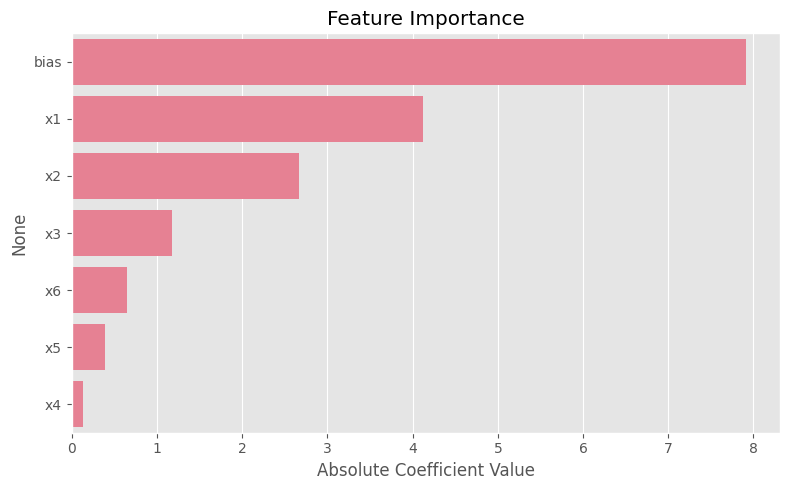

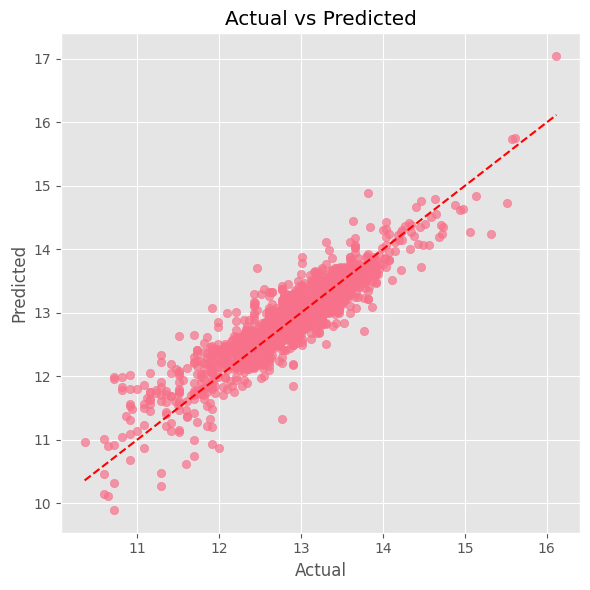

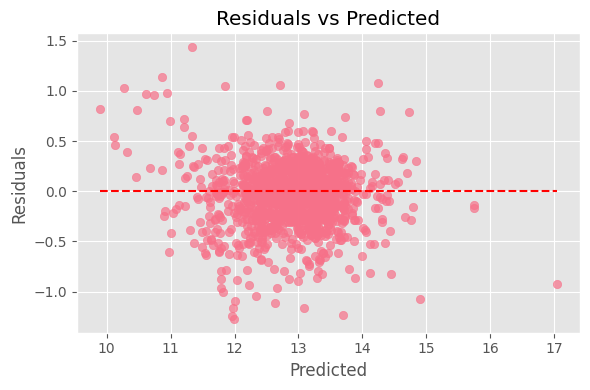

🏃 View run Ridge_Init_zeros at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/f72a9b8b277e42cdbd183306c7753af2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.098779, r2=0.822253

🚀 Running Ridge with init_method=xavier
Fold 0: 0.12342060952803702
Fold 1: 0.11526061494739273
Fold 2: 0.10691377611135544
Test MSE: 0.09771549678843482, Test R2: 0.824167748321714


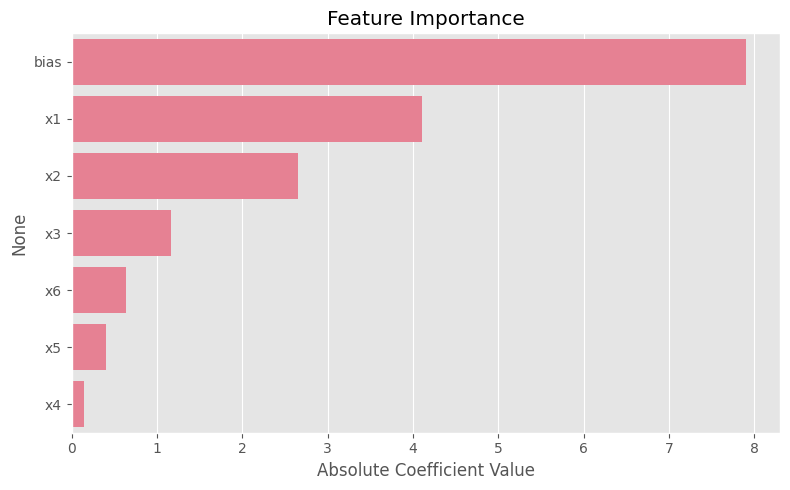

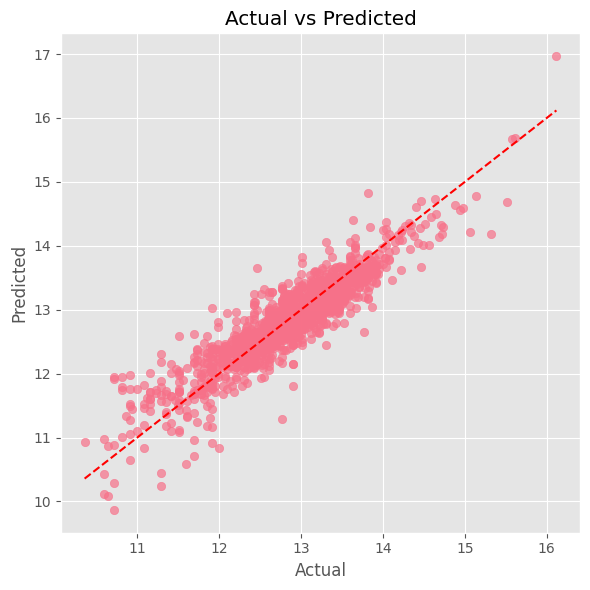

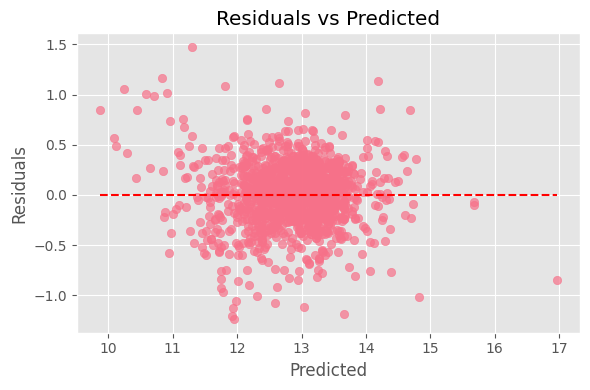

🏃 View run Ridge_Init_xavier at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/83039ad74c3e44279bc7ddfb09c0a098
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.097715, r2=0.824168


,init_method,mse,r2
0,xavier,0.097715,0.824168
1,zeros,0.098779,0.822253


In [63]:
import numpy as np
import pandas as pd
from copy import deepcopy
import mlflow

# -------------------------
# Comparison: Ridge with different initializations
# -------------------------
init_methods = ["zeros", "xavier"]
fixed_params = {
    "degree": 1,
    "method": "sto",
    "lr": 0.01,
    "use_momentum": False,
    "momentum": 0.9  # ignored since use_momentum=False
}

results_inits = []

# Use deep copies to preserve original data
X_train_copy = deepcopy(X_train)
y_train_copy = deepcopy(y_train)
X_test_copy = deepcopy(X_test)
y_test_copy = deepcopy(y_test)

for init_method in init_methods:
    print(f"\n🚀 Running Ridge with init_method={init_method}")

    try:
        # Run experiment once on full training and test data
        result = run_experiment(
            model_class="Ridge",
            X_train=X_train_copy,
            y_train=y_train_copy,
            X_test=X_test_copy,
            y_test=y_test_copy,
            degree=fixed_params["degree"],
            method=fixed_params["method"],
            init_method=init_method,
            lr=fixed_params["lr"],
            use_momentum=fixed_params["use_momentum"],
            momentum=fixed_params["momentum"],
            run_name=f"Ridge_Init_{init_method}"
        )

        mse = result["mse"]
        r2 = result["r2"]
        print(f"mse={mse:.6f}, r2={r2:.6f}")

        results_inits.append({
            "init_method": init_method,
            "mse": mse,
            "r2": r2
        })

    except Exception as e:
        print(f"❌ Experiment failed for init_method={init_method}: {e}")
        results_inits.append({
            "init_method": init_method,
            "mse": None,
            "r2": None
        })

# Final comparison table
df_inits = pd.DataFrame(results_inits).sort_values("r2", ascending=False)
df_inits.reset_index(drop=True, inplace=True)
df_inits



🚀 Running Ridge with lr=0.01
Fold 0: 0.14271612020480606
Fold 1: 0.10613091917648786
Fold 2: 0.11730889987082616
Test MSE: 0.11105209173191895, Test R2: 0.8001694717360537


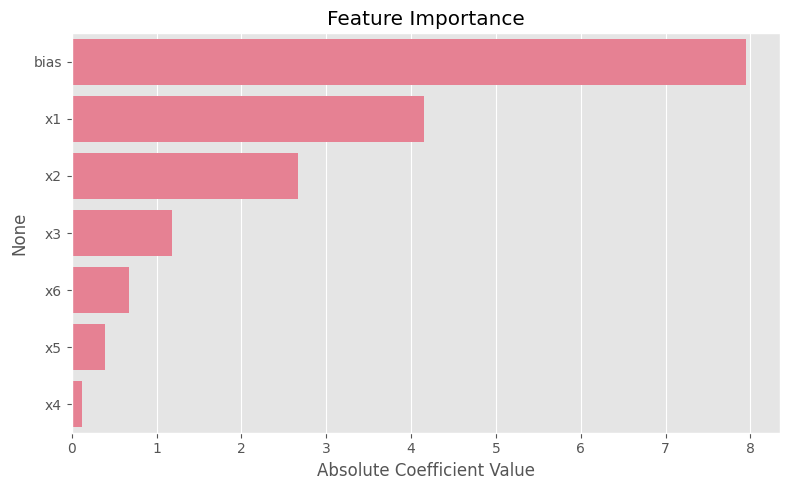

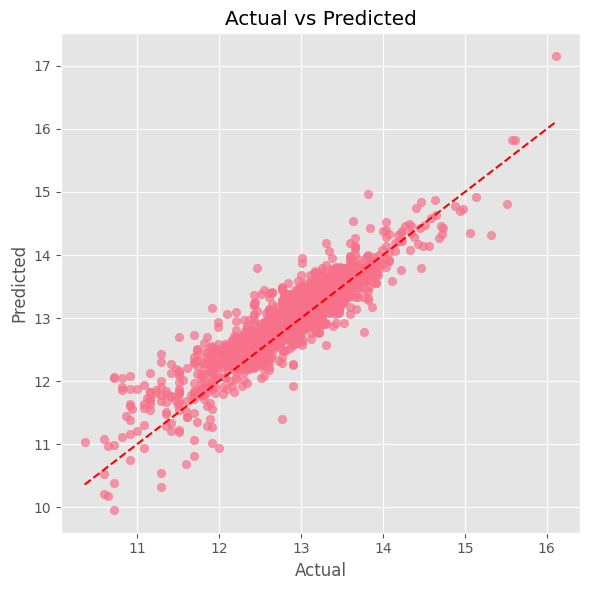

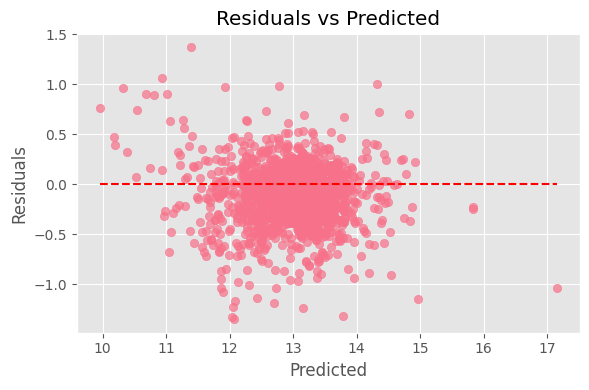

🏃 View run Ridge_lr_0.01 at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/70016b10f74442daba6d81a40bf53fac
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.111052, r2=0.800169

🚀 Running Ridge with lr=0.001
Fold 0: 0.11585698904681949
Fold 1: 0.1045563643957928
Fold 2: 0.11015933646679095
Test MSE: 0.10306280905966698, Test R2: 0.8145456311757163


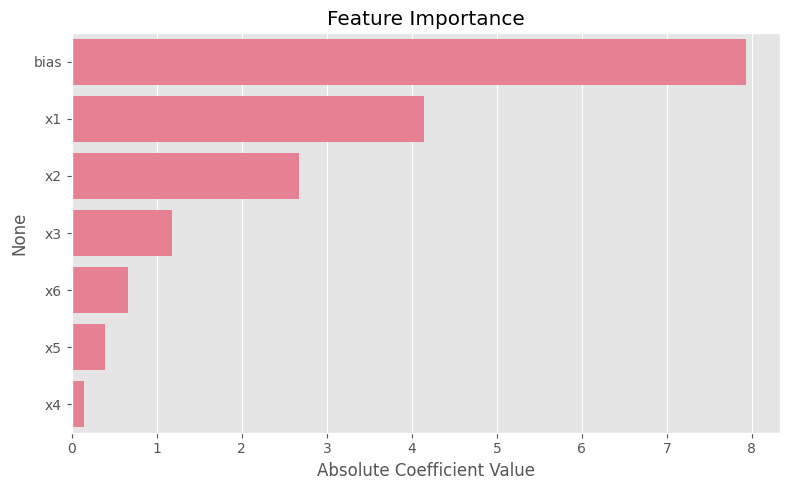

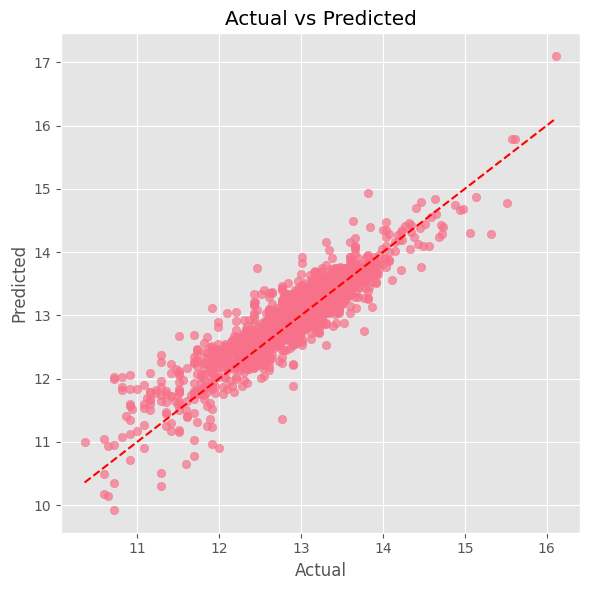

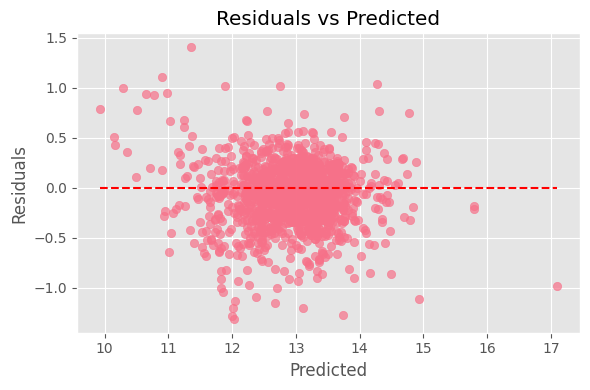

🏃 View run Ridge_lr_0.001 at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/7bc826151bfe46d58f50262e421eb6af
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.103063, r2=0.814546

🚀 Running Ridge with lr=0.0001
Fold 0: 0.1442661839080284
Fold 1: 0.10999734227016647
Fold 2: 0.14560800577394686
Test MSE: 0.14976915365428628, Test R2: 0.7305008070930551


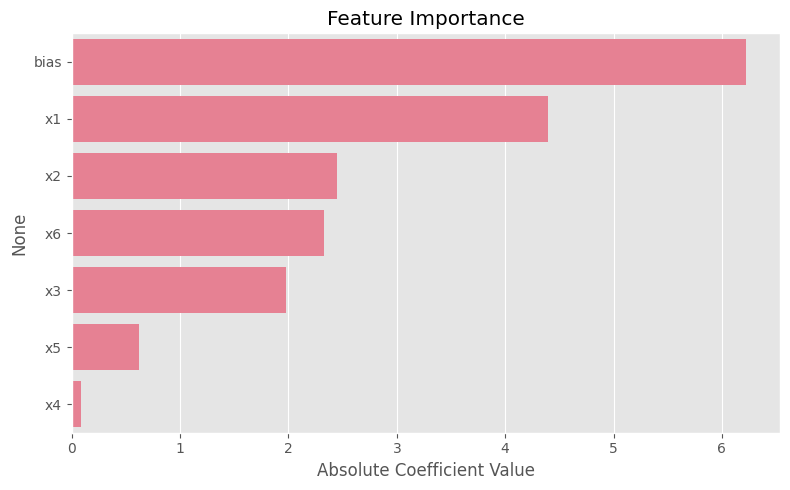

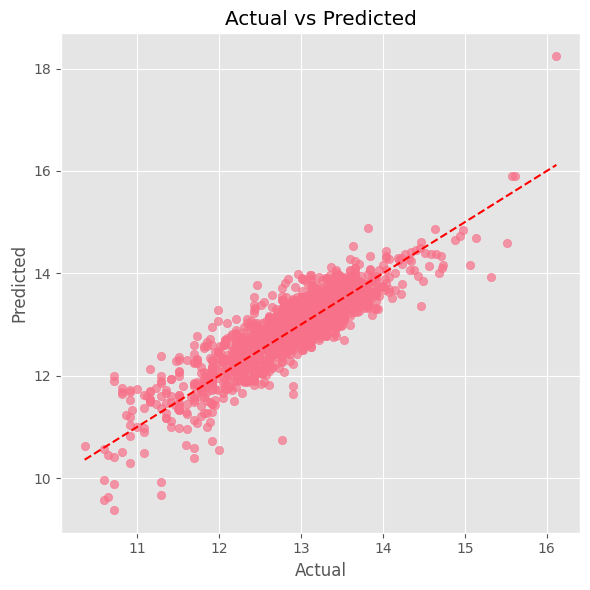

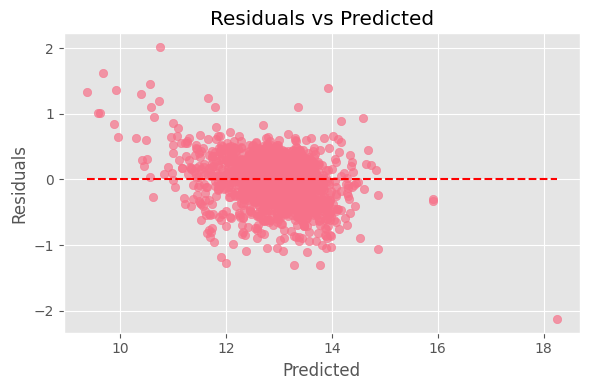

🏃 View run Ridge_lr_0.0001 at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/a5f9b0a651734ecaa30cf6522f429c5b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.149769, r2=0.730501


,learning_rate,mse,r2
0,0.0010,0.103063,0.814546
1,0.0100,0.111052,0.800169
2,0.0001,0.149769,0.730501


In [64]:
import numpy as np
import pandas as pd
from copy import deepcopy
import mlflow

# -------------------------
# Comparison: Ridge, sto, xavier, different learning rates
# -------------------------
learning_rates = [0.01, 0.001, 0.0001]
fixed_params = {
    "degree": 1,
    "method": "sto",
    "init_method": "xavier",
    "use_momentum": False,
    "momentum": 0.9  # ignored since use_momentum=False
}

results_lr = []

# Use deep copies to preserve original data
X_train_copy = deepcopy(X_train)
y_train_copy = deepcopy(y_train)
X_test_copy = deepcopy(X_test)
y_test_copy = deepcopy(y_test)

for lr in learning_rates:
    print(f"\n🚀 Running Ridge with lr={lr}")

    try:
        # Run experiment once on full training and test data
        result = run_experiment(
            model_class="Ridge",
            X_train=X_train_copy,
            y_train=y_train_copy,
            X_test=X_test_copy,
            y_test=y_test_copy,
            degree=fixed_params["degree"],
            method=fixed_params["method"],
            init_method=fixed_params["init_method"],
            lr=lr,
            use_momentum=fixed_params["use_momentum"],
            momentum=fixed_params["momentum"],
            run_name=f"Ridge_lr_{lr}"
        )

        mse = result["mse"]
        r2 = result["r2"]
        print(f"mse={mse:.6f}, r2={r2:.6f}")

        results_lr.append({
            "learning_rate": lr,
            "mse": mse,
            "r2": r2
        })

    except Exception as e:
        print(f"❌ Experiment failed for lr={lr}: {e}")
        results_lr.append({
            "learning_rate": lr,
            "mse": None,
            "r2": None
        })

# Final comparison table
df_lr = pd.DataFrame(results_lr).sort_values("r2", ascending=False)
df_lr.reset_index(drop=True, inplace=True)
df_lr


Fold 0: 0.115650655325132
Fold 1: 0.09890497676748856
Fold 2: 0.1278863535243735
Test MSE: 0.12257134882759259, Test R2: 0.7794413684222189


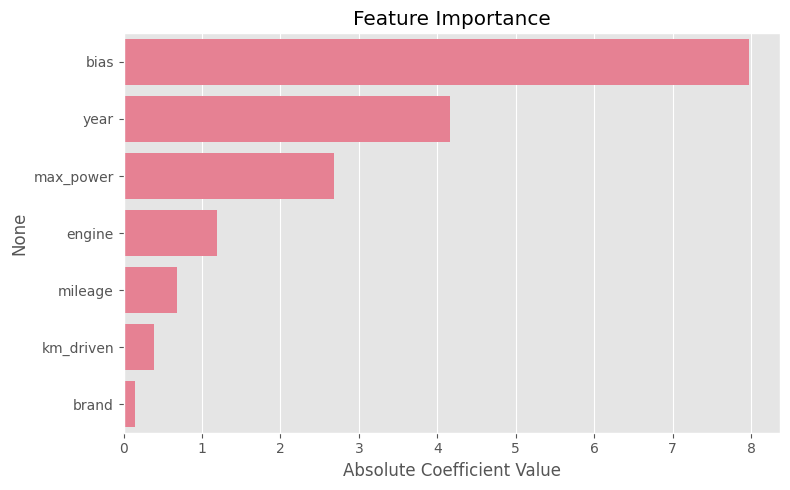

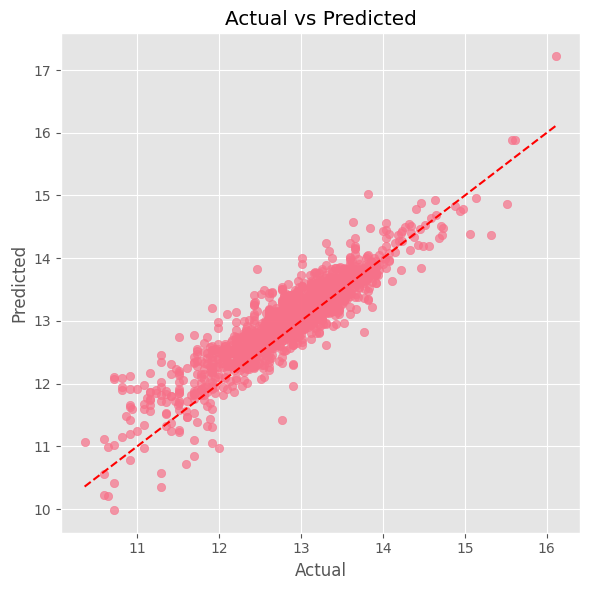

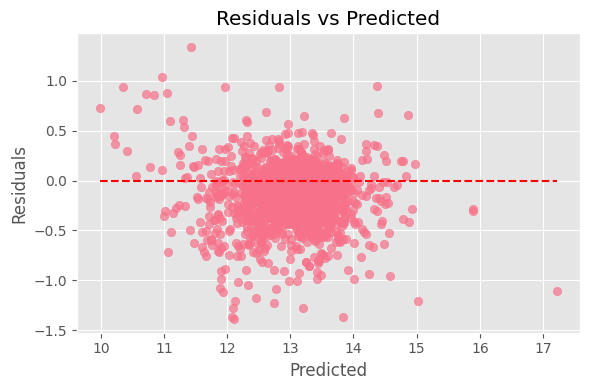

🏃 View run Experiment1 at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/bc0731ac1b5749aa9ffdff1c507b9237
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798


In [65]:
result = run_experiment(
    model_class='Ridge',
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    method='sto',
    lr=0.01,
    init_method='xavier',
    use_momentum=False,
    polynomial=True,
    degree=1,
    run_name="Experiment1"
)

model = result["model"]

In [66]:
import pickle

model_data = {
    'model': model,
    'feature_cols': model.feature_cols,
    'le_dict': model.label_encoders  # categorical encoders
}

with open('app/model/custom_car_price_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("✅ Model saved successfully")


✅ Model saved successfully


In [67]:
def predict_car_price(input_data, model_data):
    model = model_data['model']
    le_dict = model_data['le_dict']
    feature_cols = model_data['feature_cols']

    processed = []
    for col in feature_cols:
        if col in le_dict:
            try:
                processed.append(le_dict[col].transform([input_data[col]])[0])
            except ValueError:
                processed.append(0)
        else:
            processed.append(input_data[col])

    sample = np.array(processed).reshape(1, -1)
    # Predict log price
    pred_log_price = model.predict(pd.DataFrame(sample, columns=feature_cols))[0]
    # Convert back to actual price
    pred_price = np.exp(pred_log_price)
    return pred_price


In [68]:
example_car = {
    'year': 2014,
    'km_driven': 145500,
    'engine': 1248,
    'max_power': 74,
    'brand': 'Maruti',
    'mileage': 23.0
}

predicted_price = predict_car_price(example_car, model_data)
print(f"Predicted price: {predicted_price:,.0f}")


Predicted price: 399,509


# 🚗 Car Price Prediction Analysis Report

## Project Overview
This project aimed to build a **car price prediction system** for **Chaky’s company** using a dataset of **8,128 cars**.  

Key features in the dataset included:  
- `year`  
- `km_driven`  
- `fuel`  
- `owner`  
- `mileage`  
- `engine`  
- `max_power`  
- `brand`

---

## Data Preparation
We performed several preprocessing steps:

- **Owner mapping** → (e.g., *First Owner → 1, Second Owner → 2*).  
- **Removed CNG and LPG cars** (different mileage units: *km/kg vs kmpl*).  
- **Cleaned numeric columns** → stripped `"kmpl"` from mileage and `"CC"` from engine.  
- **Extracted brand** → first word from car name.  
- **Dropped torque** (inconsistent units).  
- **Removed Test Drive Cars** (unusually inflated prices).  
- **Log-transformed `selling_price`** to stabilize variation (range: 29,999 → 10,000,000).  

---

## 🔍 Exploratory Data Analysis (EDA)

To guide feature selection, we performed both **correlation analysis** and evaluated **Random Forest feature importance**. These complementary approaches allowed us to capture both linear relationships and more complex, non-linear contributions of features to car price prediction. It is important to note that correlation does not imply causation — some features may interact or overlap, so their effects should be interpreted carefully.

From this analysis, we selected **six key features** that provide strong predictive power while remaining interpretable. **Year** is highly correlated with price (0.718) and has the highest feature importance (~0.518), reflecting the premium placed on newer cars. **Max_power** (0.637 correlation, ~0.335 importance) captures the value associated with performance-oriented or premium models, while **Engine** size (0.468 correlation, ~0.078 importance) distinguishes larger, more luxurious or powerful vehicles. **Km_driven** shows a weak negative correlation (-0.185, ~0.020 importance), indicating that higher mileage slightly reduces price. **Mileage** (0.152 correlation, ~0.043 importance) now contributes positively, showing that fuel-efficient cars are slightly more valued. **Brand**, although minimally correlated (-0.018) with a small importance (~0.025), contributes subtly through perceived prestige. Several features were excluded: **Owner**, **Fuel Type**, **Transmission**, and **Seats**, either overlapping with the selected features or showing low variability. Removing these did not reduce model performance (R² remained ~0.90), confirming that the six selected features capture the most relevant information for predicting car prices.

---

## ✅ Selected Features

We chose **6 features** for predictive power and interpretability:

| Feature      | Correlation | Importance | Rationale |
|--------------|-------------|------------|-----------|
| **Year**     | **0.718**   | ~0.518      | Newer cars command higher prices due to less wear and modern tech. |
| **Max_power**| **0.637**   | ~0.335      | Stronger engines → premium/sport models. |
| **Engine**   | **0.468**   | ~0.078      | Bigger engines → luxury/performance cars. |
| **Km_driven**| **-0.185**  | ~0.020      | More mileage reduces price, but weaker than expected. |
| **Mileage**  | **0.018**   | ~0.022      | Higher efficiency slightly boosts value. |
| **Brand**    | **-0.018**  | ~0.025      | Premium perception boosts price (e.g., BMW vs Maruti). |

### Examples:
- **Year**: 2018 Honda City → 925,000 vs 2006 Honda City → 158,000.  
- **Max_power**: Jeep Compass (160.77 bhp, 2,100,000) vs Maruti Alto (47.3 bhp, 275,000).  
- **Engine**: Toyota Fortuner (2982 CC, 1,500,000) vs Maruti 800 (796 CC, 45,000).  
- **Km_driven**: Swift (145,500 km → 450,000) vs Swift (35,000 km → 675,000).  
- **Mileage**: Maruti Swift (23 kmpl → 675,000) vs older hatchback (18 kmpl → 420,000).  
- **Brand**: Mercedes-Benz B Class → 1,450,000 vs Maruti Alto → 275,000.  

---

## ❌ Skipped Features

| Feature       | Correlation | Reason for Exclusion |
|---------------|-------------|-----------------------|
| **Owner**     | -0.389 | Dropping didn’t reduce R² (0.90). Effect captured by `year` + `km_driven`. |
| **Fuel Type** | -0.356 | Correlates with `engine` size. Adds redundancy. |
| **Transmission** | -0.343 | Overlaps with `max_power` and `engine`. |
| **Seats**     | 0.273 | Low variation (mostly 5 seats). Limited influence. |

---

## 📊 Model Comparison

We tested multiple ML models with the selected 6 features:

| Model               | R² Score |
|--------------------|----------|
| **Random Forest**    | **0.9016** |
| Decision Tree        | 0.8411    |
| Linear Regression    | 0.8239    |
| K-Neighbors (KNN)    | 0.8831    |
| Support Vector Regr. | 0.8713    |

---

## 🚀 Conclusion
This first AI project successfully demonstrates how **machine learning can estimate car prices** using a small, impactful feature set.  

For Chaky’s company, this system now accounts for **fuel efficiency** through mileage, offering:  
- **Ease of data collection**  
- **Strong predictive power**  
- **Simple web-app integration**
